In [1]:
from mobster_mv import mobster_MV
from plot_functions import plot_marginals, plot_deltas, plot_paretos, plot_betas
from create_beta_pareto_dataset import pareto_binomial_component, beta_binomial_component, only_pareto_binomial_component
import numpy as np
import pandas as pd
import pyro.distributions as dist
from BoundedPareto import BoundedPareto
from scipy.stats import pareto, beta, uniform, norm, lognorm


import torch
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.metrics.cluster import normalized_mutual_info_score
import warnings


%load_ext autoreload
%autoreload 2

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_paretos_1(mb):
    alpha_pareto = mb.params["alpha_pareto"]
    fig, ax = plt.subplots(nrows=alpha_pareto.shape[0], ncols=alpha_pareto.shape[1])
    fig.tight_layout()
    x = np.arange(0,0.5,0.001)
    k = 0
    for d in range(alpha_pareto.shape[1]):
        pdf = pareto.pdf(x, alpha_pareto[k,d], scale=0.01)
        ax[d].plot(x, pdf, 'r-', lw=1)
        ax[d].set_title(f"Dimension {d} - alpha {round(float(alpha_pareto[k,d]), ndigits=2)}")

def plot_betas_1(mb):
    phi_beta = mb.params["phi_beta"]
    kappa_beta = mb.params["k_beta"]

    fig, ax = plt.subplots(nrows=phi_beta.shape[0], ncols=phi_beta.shape[1])
    fig.tight_layout()
    x = np.arange(0,1,0.001)
    k = 0
    for d in range(phi_beta.shape[1]):
        a = phi_beta[k,d]*kappa_beta[k,d]
        b = (1-phi_beta[k,d])*kappa_beta[k,d]
        pdf = beta.pdf(x, a, b)
        ax[d].plot(x, pdf, 'r-', lw=1)
        ax[d].set_title(f"Dimension {d}")

In [3]:
def log_sum_exp(args):
    c = torch.amax(args, dim=0)
    return c + torch.log(torch.sum(torch.exp(args - c), axis=0)) # sum over the rows (different clusters), so obtain a single likelihood for each data

def beta_lk(data, DP, probs_beta, a_beta, b_beta, weights):
    K = 1

    return torch.log(weights) + dist.Beta(a_beta, b_beta).log_prob(probs_beta) + dist.Binomial(total_count=DP, probs = probs_beta).log_prob(data) # simply does log(weights) + log(density)


def pareto_lk(data, DP, probs_pareto, alpha, weights):
    K = 1
    return torch.log(weights) + BoundedPareto(0.01, alpha, 0.55).log_prob(probs_pareto) + dist.Binomial(total_count=DP, probs = probs_pareto).log_prob(data) # simply does log(weights) + log(density)


def compute_likelihood(mb, beta = True, dim = 0, k = 0):
    NV = mb.NV[:, dim]
    DP = mb.DP[:, dim]
    weights = mb.params["weights"][k]
    if beta == True:
        phi_beta = mb.params["phi_beta"][k, dim]
        k_beta = mb.params["k_beta"][k, dim]
        a_beta = phi_beta * k_beta
        b_beta = (1-phi_beta) * k_beta
        probs_beta = mb.params["probs_beta"][k, dim]
        return log_sum_exp(beta_lk(NV, DP, probs_beta, a_beta, b_beta, weights)).sum()
    else:
        alpha = mb.params["alpha_pareto"][k, dim]
        probs_pareto = mb.params["probs_pareto"][k, dim]
        return log_sum_exp(pareto_lk(NV, DP, probs_pareto, alpha, weights)).sum()

### One beta component

Trying to understand if the problem is the $\delta$ or the parameter convergence:
- if one dim of the cluster is assigned to the pareto but the likelihood of beta is higher, then the $\delta$ is wrong
- if one dim of the cluster is assigned to the pareto and the likelihood of pareto is higher, then the parameter convergence is wrong

In [103]:
N1 = 1000
seed = 123
# Component 1
phi_beta_x = 0.1
k_beta_x = 250
phi_beta_y = 0.1
k_beta_y= 250
n1=150
NV, DP = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n1, N=N1, seed=seed)
# 
print(DP.shape)

torch.Size([1000, 2])


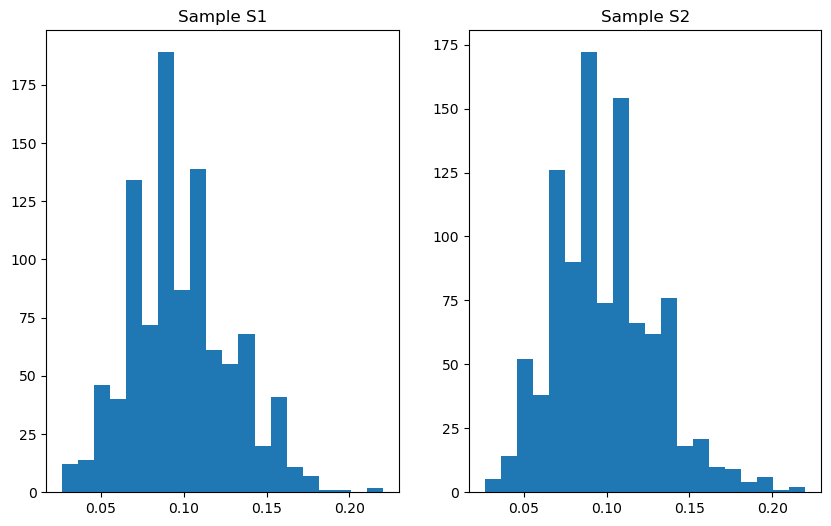

In [105]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 20)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 20)
axes[1].set_title("Sample S2")
plt.show()

In [106]:
labels = np.zeros(N1)

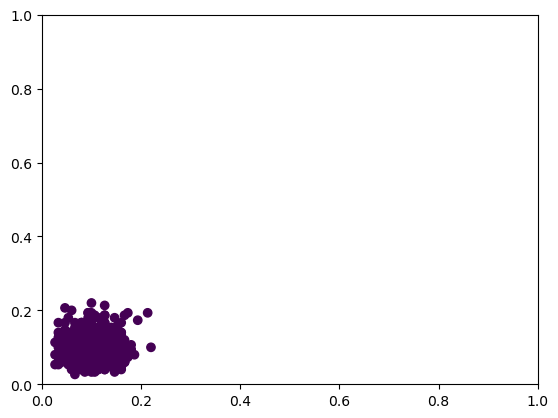

In [107]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[0.0986, 0.0994]])
Iteration 0: Loss = -6599.21728515625
weights_param tensor([1.], grad_fn=<DivBackward0>)
delta_param tensor([[[0.3586, 0.6414],
         [0.3318, 0.6682]]], grad_fn=<DivBackward0>)
alpha_param tensor([[1.9980, 1.9980]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0987, 0.0995]], grad_fn=<ClampBackward1>)
k_beta_param tensor([[200.2001, 200.2001]], grad_fn=<AddBackward0>)
probs_beta_param tensor([[0.0985, 0.0994]], grad_fn=<ClampBackward1>)
probs_pareto_param tensor([[0.0985, 0.0994]], grad_fn=<ClampBackward1>)


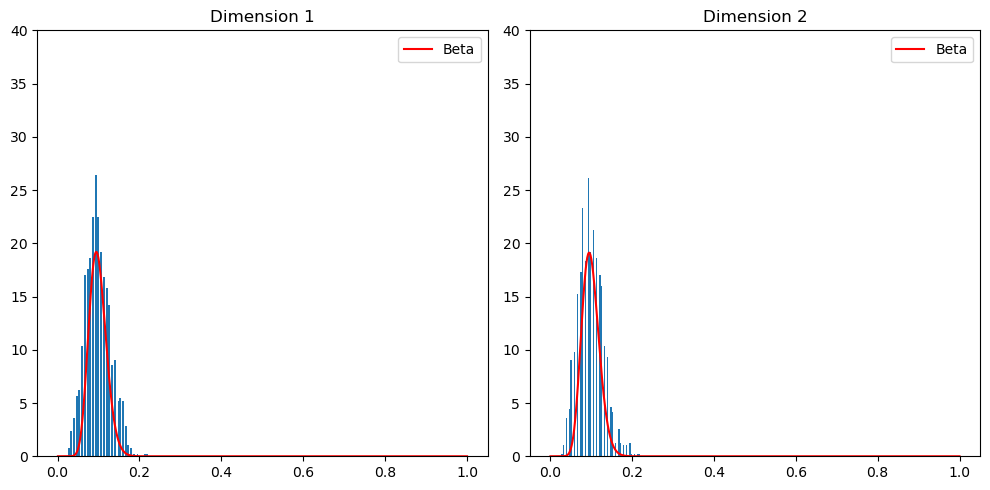

Iteration 200: Loss = -6941.3642578125
Iteration 400: Loss = -7101.94287109375
probs_beta [[0.08637262 0.08688047]]


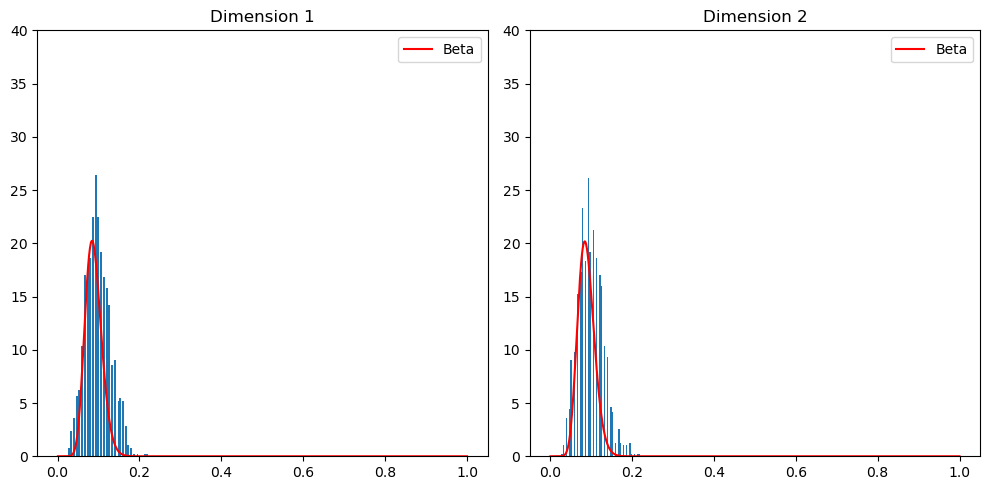

Iteration 600: Loss = -7208.9013671875
Iteration 800: Loss = -7284.23974609375
probs_beta [[0.08622937 0.08669081]]


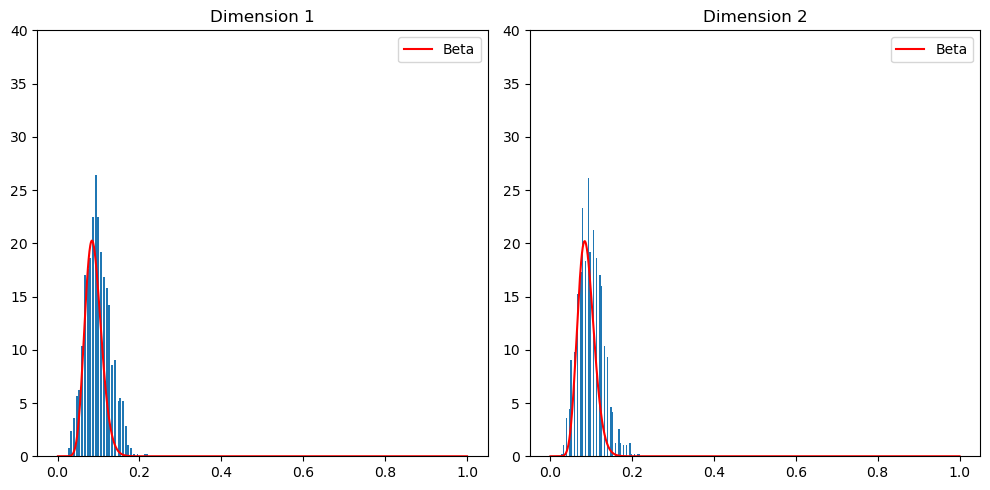

Iteration 1000: Loss = -7338.89404296875
Iteration 1200: Loss = -7379.5361328125
probs_beta [[0.08622922 0.08668849]]


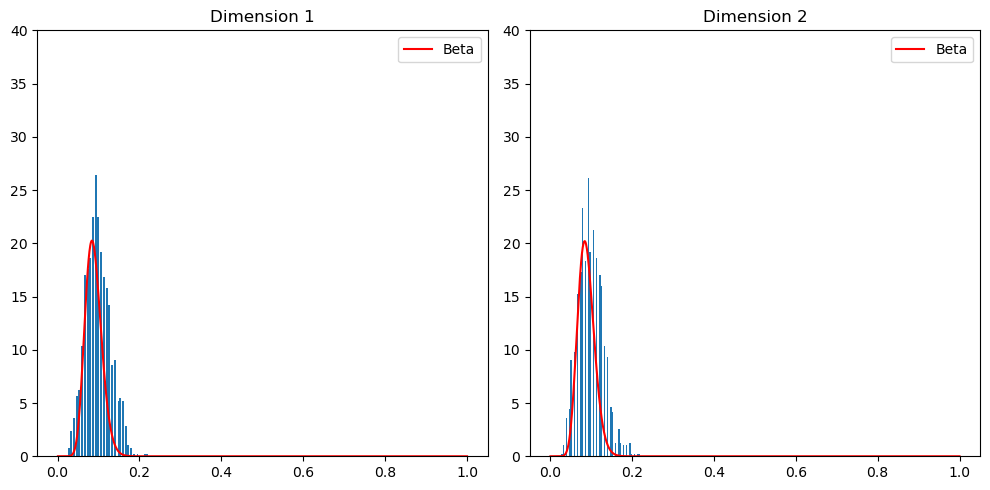

Iteration 1400: Loss = -7410.3974609375
Iteration 1600: Loss = -7434.70263671875
probs_beta [[0.08622922 0.08668602]]


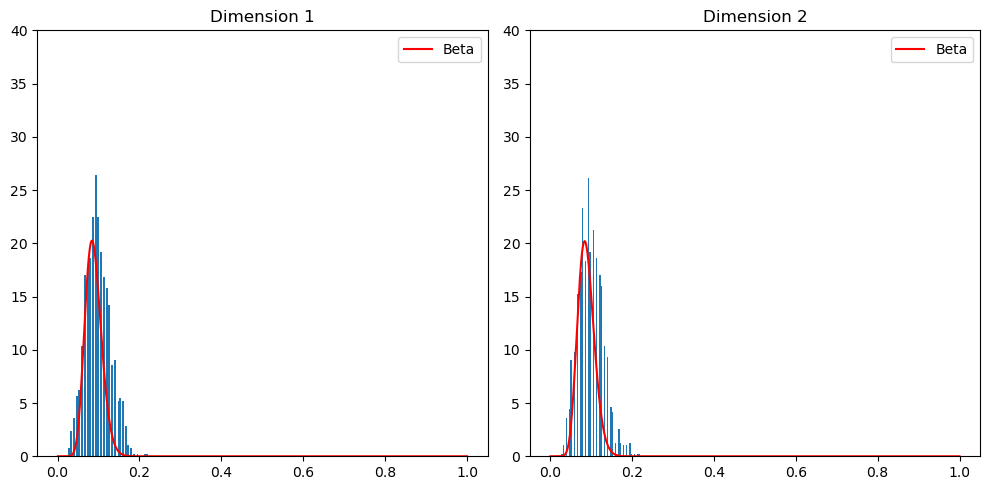

Iteration 1800: Loss = -7454.06298828125
Iteration 2000: Loss = -7469.583984375
probs_beta [[0.08622897 0.08668285]]


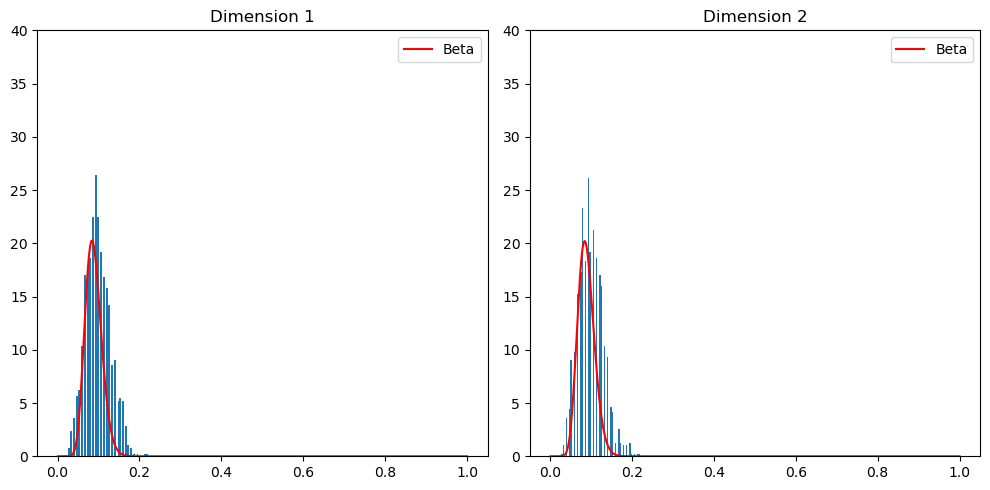

Iteration 2200: Loss = -7482.39501953125
Iteration 2400: Loss = -7493.1884765625
probs_beta [[0.08622832 0.08667982]]


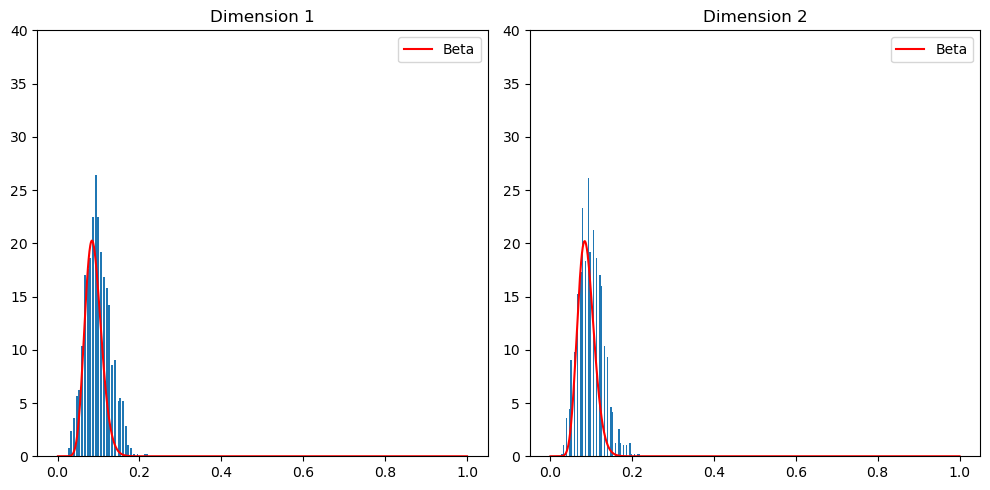

Iteration 2600: Loss = -7502.2490234375
Iteration 2800: Loss = -7510.00634765625
probs_beta [[0.08622751 0.08667783]]


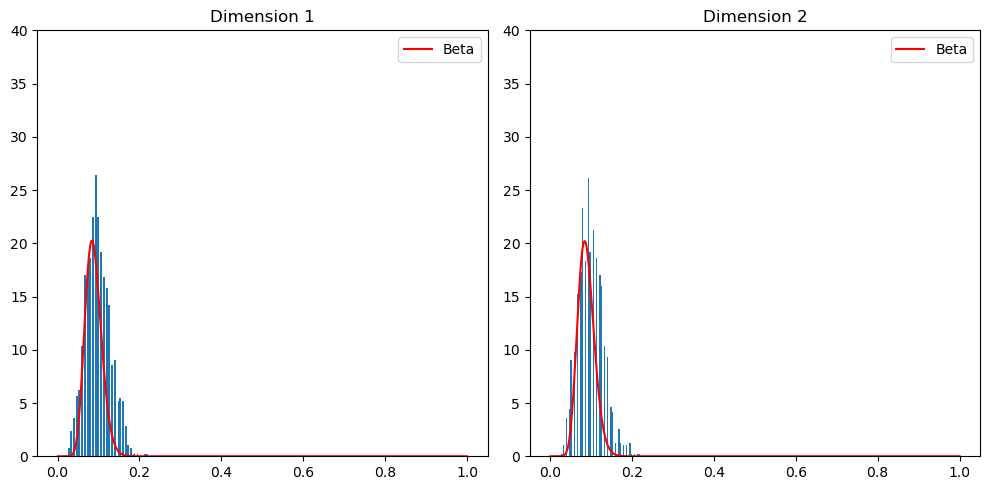

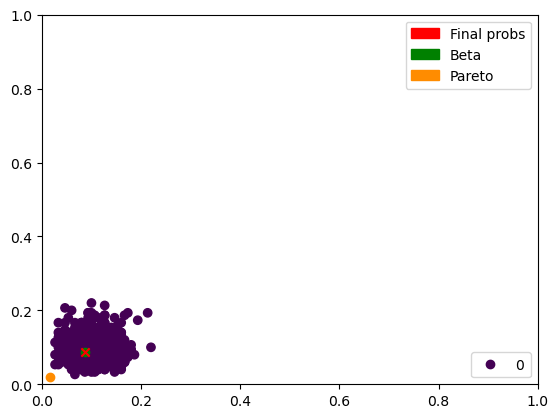

In [108]:
mb = mobster_MV(NV, DP, K = 1, seed = 53)
mb.fit(num_iter = 3000, lr = 0.001)

In [113]:
print(compute_likelihood(mb, beta = True, dim = 0, k = 0))
print(compute_likelihood(mb, beta = False, dim = 0, k = 0))

print(compute_likelihood(mb, beta = True, dim = 1, k = 0))
print(compute_likelihood(mb, beta = False, dim = 1, k = 0))

tensor(7.2213)
tensor(4.3012)
tensor(7.2184)
tensor(3.9038)


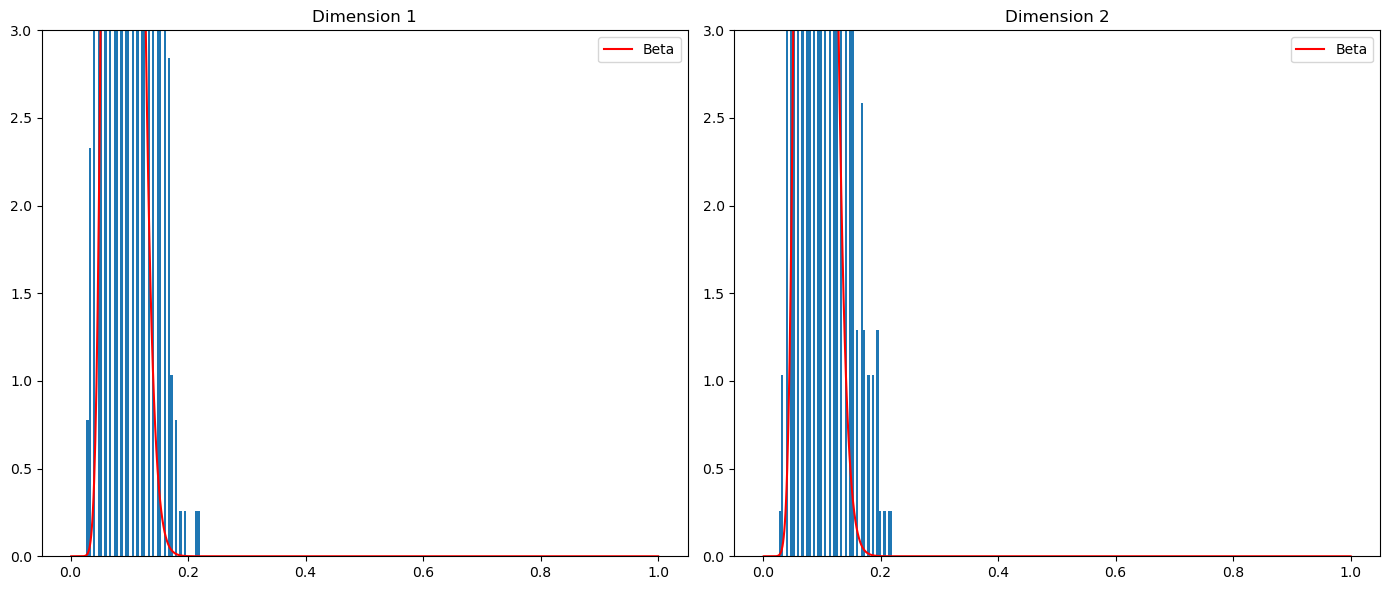

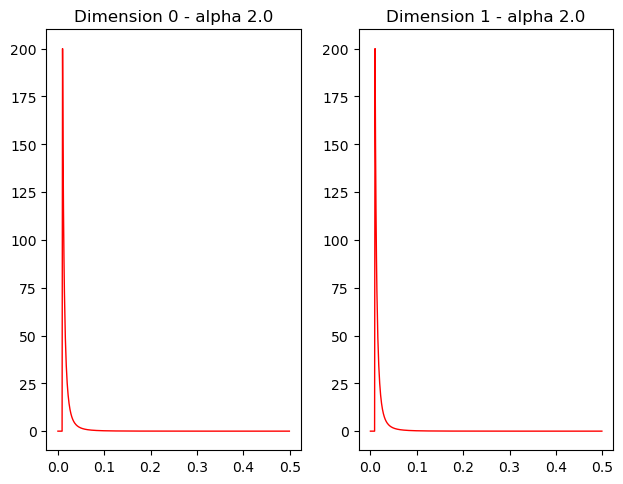

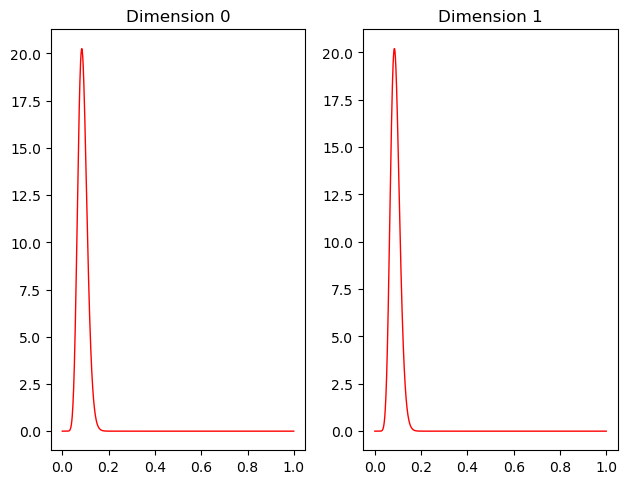

In [110]:
plot_marginals(mb)
# plot_deltas(mb)
plot_paretos_1(mb)
plot_betas_1(mb)

In [111]:
mb.params

{'probs_beta': tensor([[0.0862, 0.0867]]),
 'probs_pareto': tensor([[0.0173, 0.0186]]),
 'weights': tensor([1.]),
 'delta': tensor([[[0.0239, 0.9761],
          [0.0216, 0.9784]]]),
 'alpha_pareto': tensor([[2.0001, 2.0000]]),
 'phi_beta': tensor([[0.0883, 0.0887]]),
 'k_beta': tensor([[200.6220, 200.6229]]),
 'responsib': tensor([[0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.

Ho notato che inizialmente mette la pareto su entrambe le dimensioni, ma aumentando il numero di iterazioni il valore p della beta diminuisce finchè non arriva a 0.1 quindi il delta indica una beta. Aumentando ancora il numero di iterazioni la p però continua a scendere e quindi fitta nuovamente la pareto. BOH

### One pareto-pareto component

In [27]:
N1 = 1000
seed = 123

n1=100
NV, DP = only_pareto_binomial_component(alpha_x=2, L_x=0.01, H_x=0.5, alpha_y=2, L_y=0.01, H_y=0.5, n=n1, N=N1, seed = 123)

print(DP.shape)

torch.Size([1000, 2])


In [28]:
"""
NV = torch.ones([N1, 2]) # component 1
alpha_x=2
L_x=0.01
H_x=0.5
alpha_y=2
L_y=0.01
H_y=0.5
n=100
# x-axis component 1
NV[:, 0] = BoundedPareto(scale=L_x, alpha = alpha_x, upper_limit = H_x).sample([N1]).float()
NV[:, 1] = BoundedPareto(scale=L_y, alpha = alpha_y, upper_limit = H_y).sample([N1]).float()

DP = torch.ones([N1, 2]) * n
"""

'\nNV = torch.ones([N1, 2]) # component 1\nalpha_x=2\nL_x=0.01\nH_x=0.5\nalpha_y=2\nL_y=0.01\nH_y=0.5\nn=100\n# x-axis component 1\nNV[:, 0] = BoundedPareto(scale=L_x, alpha = alpha_x, upper_limit = H_x).sample([N1]).float()\nNV[:, 1] = BoundedPareto(scale=L_y, alpha = alpha_y, upper_limit = H_y).sample([N1]).float()\n\nDP = torch.ones([N1, 2]) * n\n'

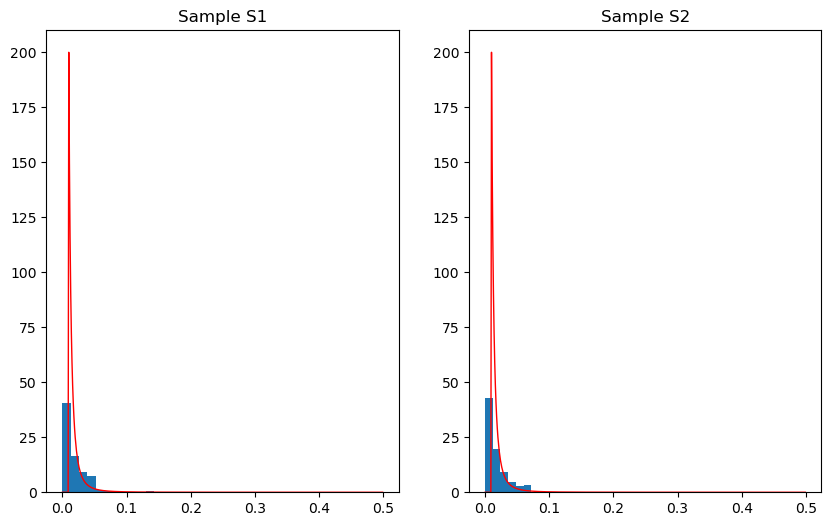

In [29]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), density = True, bins = 20)
axes[0].set_title("Sample S1")

x = np.arange(0, 0.5, 0.001)
pdf = pareto.pdf(x, 2.0, scale=0.01)
axes[0].plot(x, pdf, 'r-', lw=1)

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), density = True, bins = 20)
axes[1].set_title("Sample S2")
axes[1].plot(x, pdf, 'r-', lw=1)
plt.show()

In [30]:
labels = np.zeros(N1)

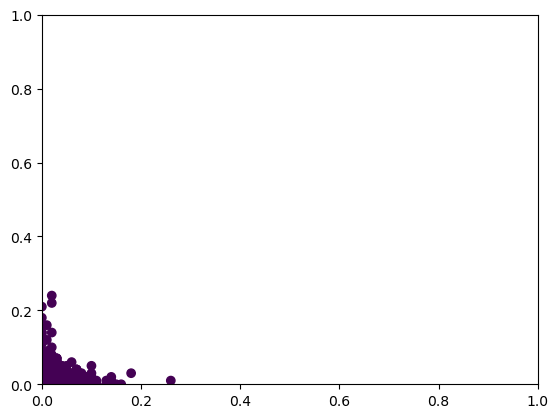

In [31]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[0.0191, 0.0195]])
Iteration 0: Loss = -10907.1455078125
weights_param tensor([1.], grad_fn=<DivBackward0>)
delta_param tensor([[[0.3586, 0.6414],
         [0.3318, 0.6682]]], grad_fn=<DivBackward0>)
alpha_param tensor([[1.9980, 1.9980]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0191, 0.0195]], grad_fn=<ClampBackward1>)
k_beta_param tensor([[200.2001, 200.2001]], grad_fn=<AddBackward0>)
probs_beta_param tensor([[0.0190, 0.0194]], grad_fn=<ClampBackward1>)
probs_pareto_param tensor([[0.0190, 0.0194]], grad_fn=<ClampBackward1>)


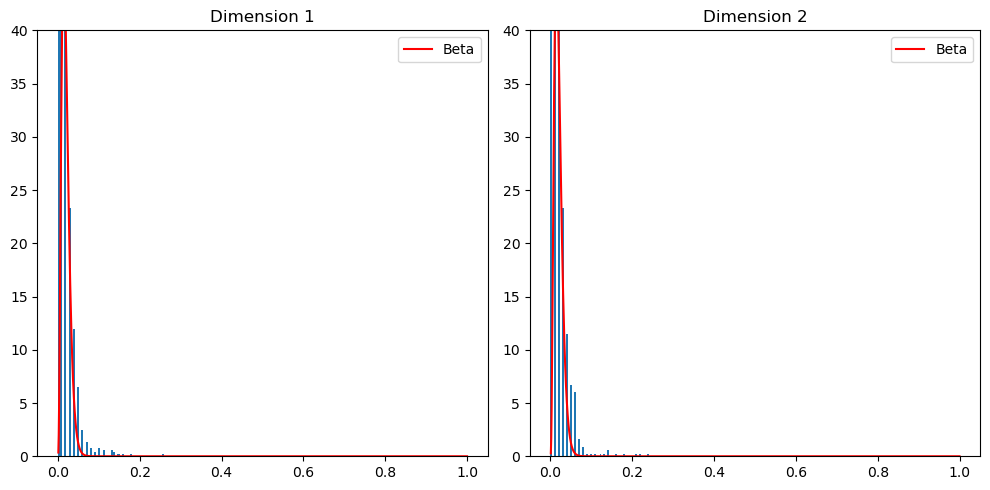

Iteration 200: Loss = -11579.5771484375
Iteration 400: Loss = -12730.0185546875
probs_beta [[0.01443452 0.01461469]]


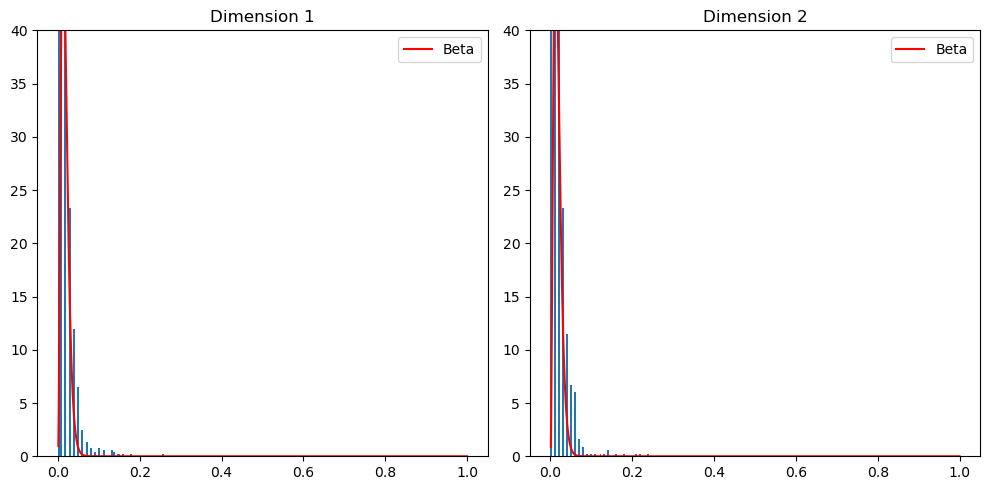

Iteration 600: Loss = -14637.685546875
Iteration 800: Loss = -16459.673828125
probs_beta [[0.01351401 0.01357516]]


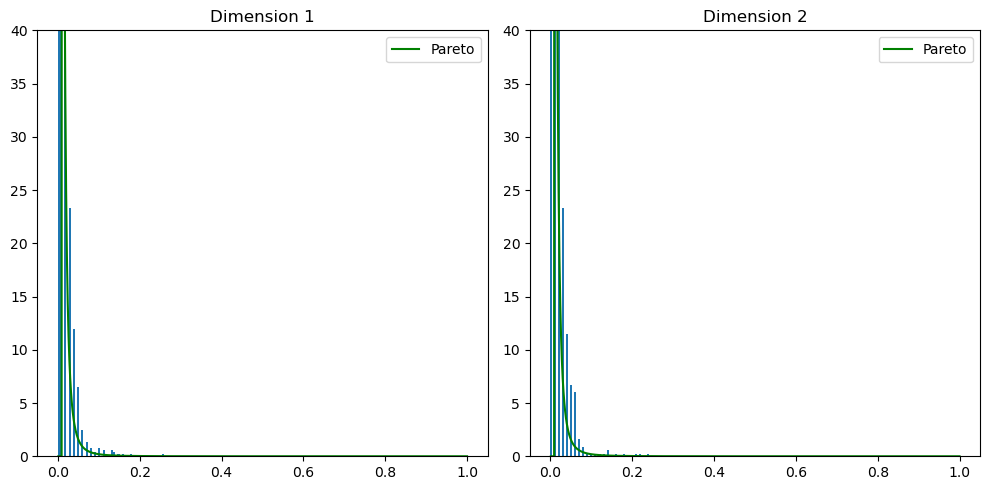

Iteration 1000: Loss = -18070.603515625
Iteration 1200: Loss = -19543.5703125
probs_beta [[0.01339202 0.01344709]]


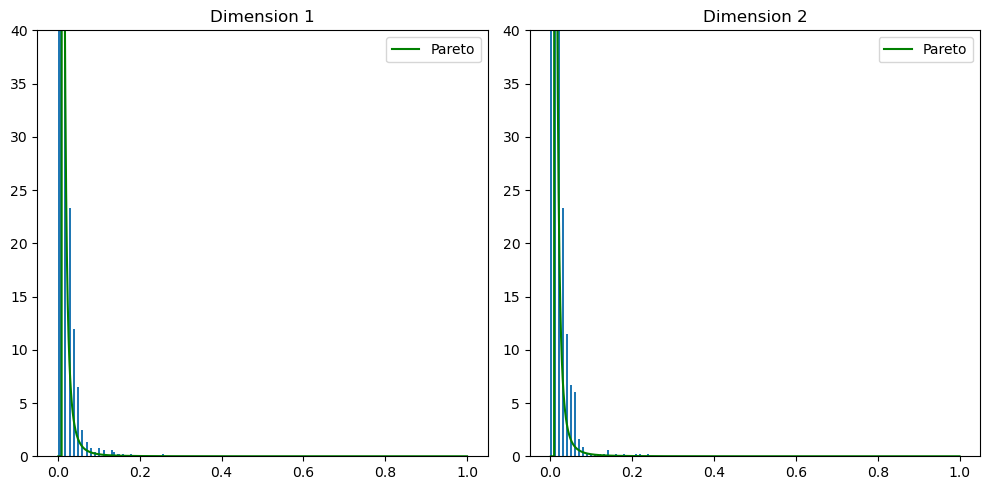

Iteration 1400: Loss = -20933.865234375
Iteration 1600: Loss = -22274.1484375
probs_beta [[0.01336035 0.01341552]]


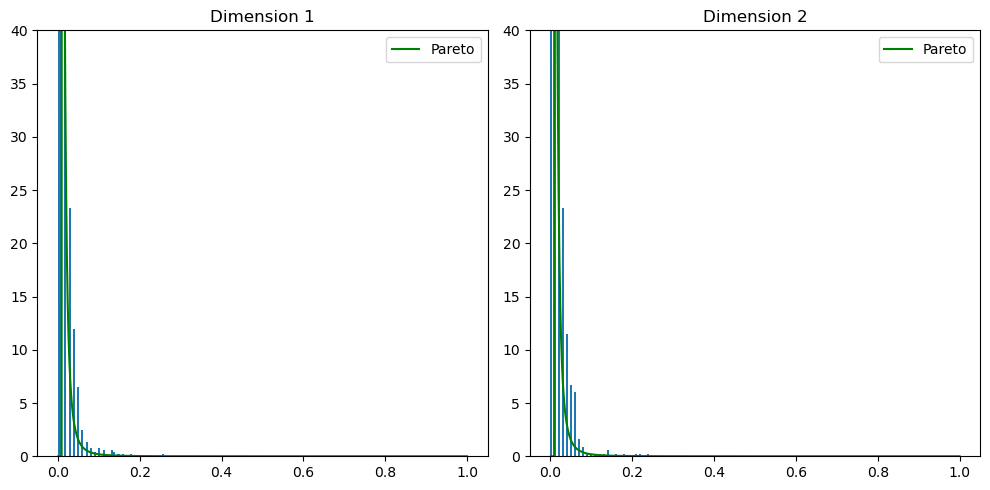

Iteration 1800: Loss = -23583.6875
Iteration 2000: Loss = -24874.18359375
probs_beta [[0.01334205 0.01339746]]


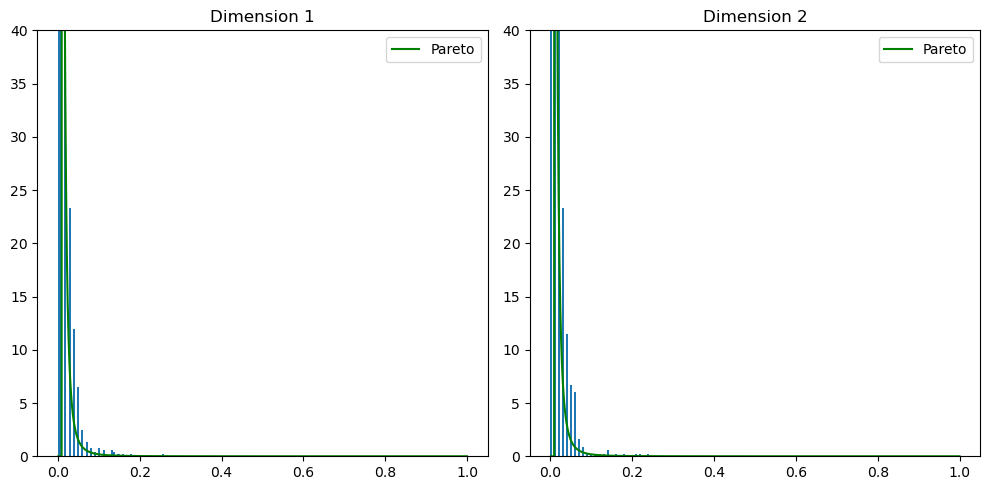

Iteration 2200: Loss = -26152.873046875
Iteration 2400: Loss = -27424.353515625
probs_beta [[0.01332364 0.01337982]]


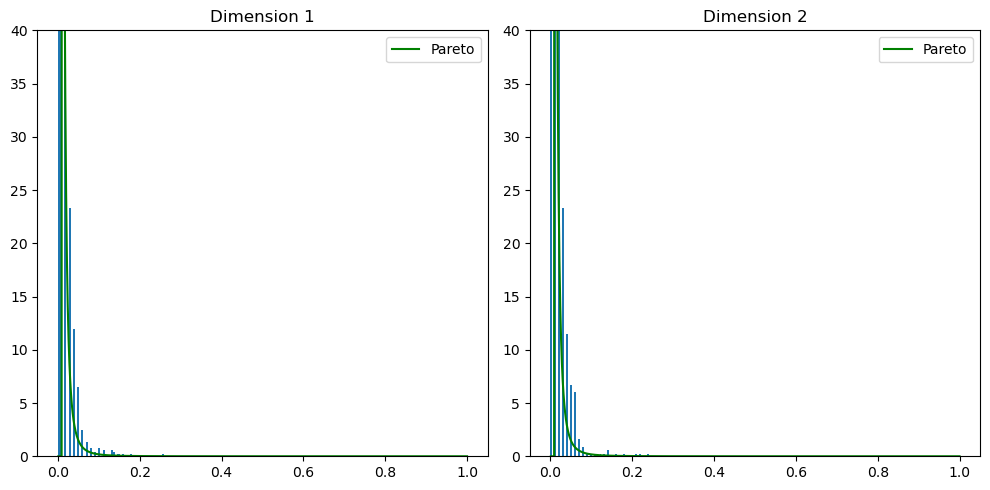

Iteration 2600: Loss = -28691.490234375
Iteration 2800: Loss = -29956.15234375
probs_beta [[0.01330172 0.0133592 ]]


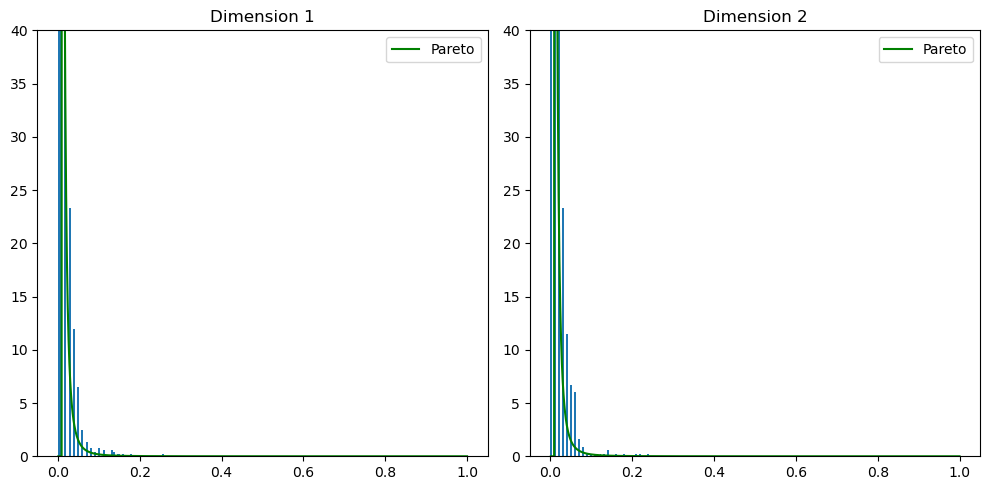

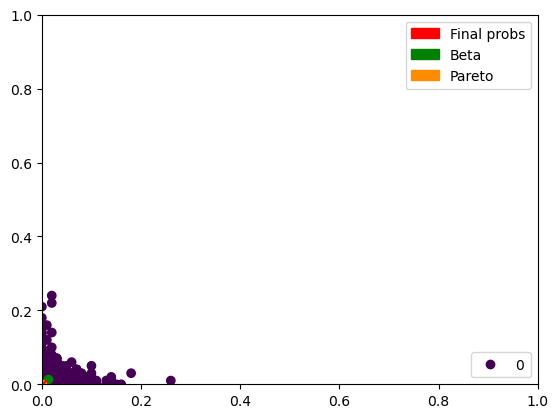

In [39]:
mb = mobster_MV(NV, DP, K = 1, seed = 53)
mb.fit(num_iter = 3000, lr = 0.001)

In [40]:
print(compute_likelihood(mb, beta = True, dim = 0, k = 0))
print(compute_likelihood(mb, beta = False, dim = 0, k = 0))

tensor(9.3523)
tensor(19.1984)


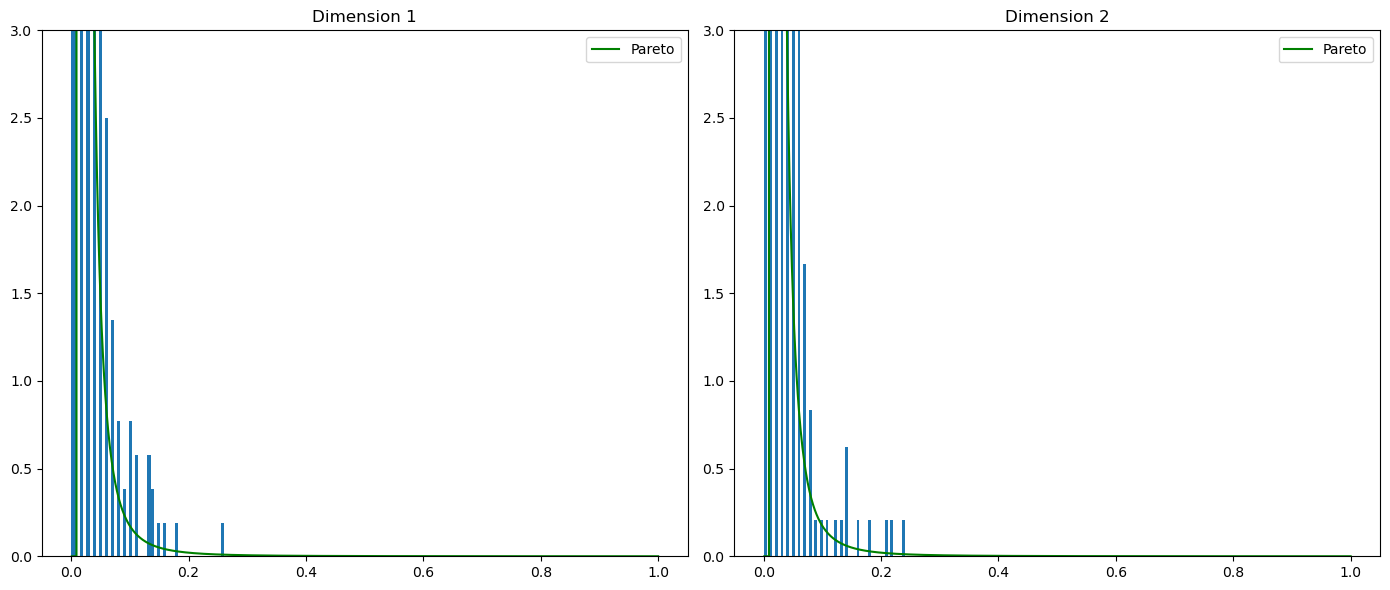

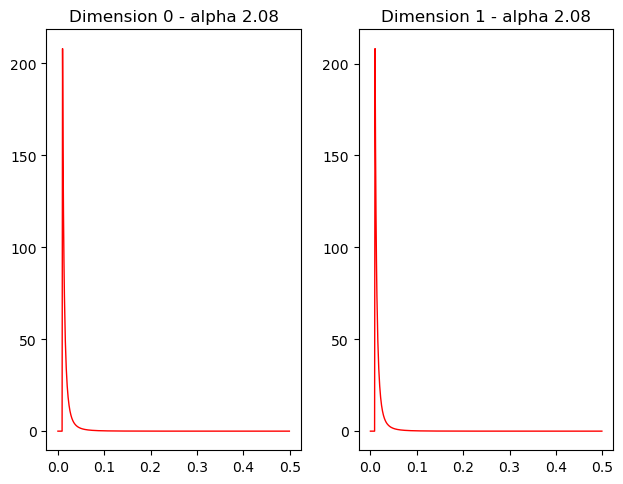

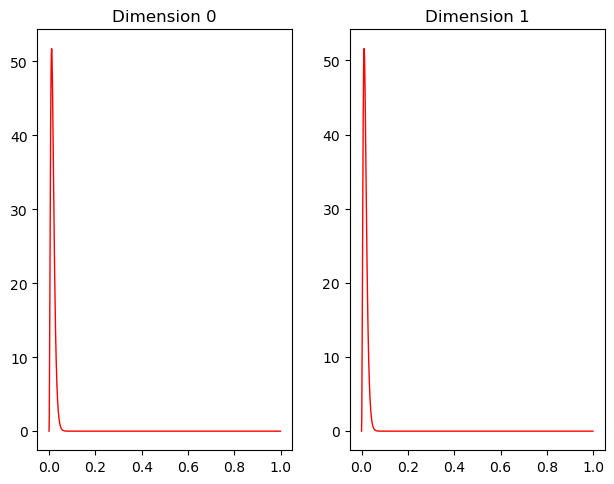

In [41]:
plot_marginals(mb)
# plot_deltas(mb)
plot_paretos_1(mb)
plot_betas_1(mb)

In [42]:
mb.params

{'probs_beta': tensor([[0.0133, 0.0133]]),
 'probs_pareto': tensor([[0.0006, 0.0006]]),
 'weights': tensor([1.]),
 'delta': tensor([[[0.9711, 0.0289],
          [0.9681, 0.0319]]]),
 'alpha_pareto': tensor([[2.0805, 2.0810]]),
 'phi_beta': tensor([[0.0161, 0.0161]]),
 'k_beta': tensor([[200.0005, 200.0009]]),
 'responsib': tensor([[1.1344e-08, 1.1344e-08, 1.1344e-08, 1.1344e-08, 1.1344e-08, 1.1344e-08,
          1.1344e-08, 1.1344e-08, 1.1344e-08, 1.1344e-08, 1.1344e-08, 1.1344e-08,
          1.1344e-08, 1.1344e-08, 1.1344e-08, 1.1344e-08, 1.1344e-08, 1.1344e-08,
          1.1344e-08, 1.1344e-08, 1.1344e-08, 1.1344e-08, 1.1344e-08, 1.1344e-08,
          1.1344e-08, 1.1344e-08, 1.1344e-08, 1.1344e-08, 1.1344e-08, 1.1344e-08,
          1.1344e-08, 1.1344e-08, 1.1344e-08, 1.1344e-08, 1.1344e-08, 1.1344e-08,
          1.1344e-08, 1.1344e-08, 1.1344e-08, 1.1344e-08, 1.1344e-08, 1.1344e-08,
          1.1344e-08, 1.1344e-08, 1.1344e-08, 1.1344e-08, 1.1344e-08, 1.1344e-08,
          1.1344e-08

### One beta-pareto component

In [39]:
N1 = 1000
N2 = 500
seed = 123
# Sample S1
alpha_pareto = 2
L_pareto = 0.01
H_pareto = 0.3
phi_beta = 0.1
k_beta = 200
n1 = 100
NV, DP = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)

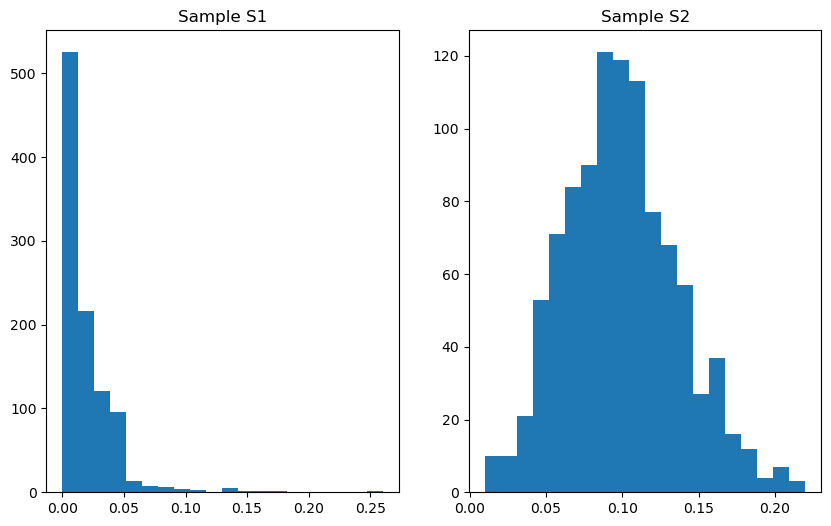

In [40]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 20)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 20)
axes[1].set_title("Sample S2")
plt.show()

In [41]:
labels = np.zeros(N1)

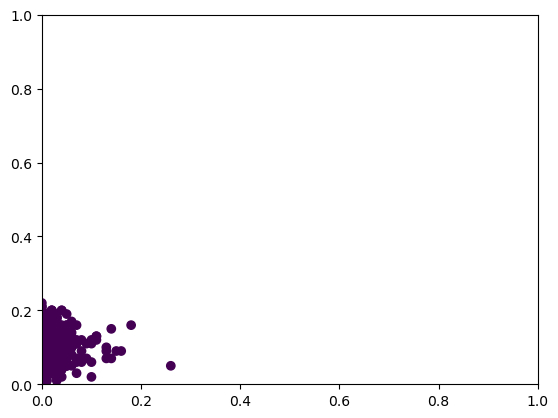

In [42]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[0.0191, 0.1002]])
Iteration 0: Loss = -9241.982421875
weights_param tensor([1.], grad_fn=<DivBackward0>)
delta_param tensor([[[0.0250, 0.9750],
         [0.2420, 0.7580]]], grad_fn=<DivBackward0>)
alpha_param tensor([[1.9980, 1.9980]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0191, 0.1003]], grad_fn=<AddBackward0>)
k_beta_param tensor([[200.2001, 200.2001]], grad_fn=<AddBackward0>)
probs_beta_param tensor([[0.0190, 0.1001]], grad_fn=<AddBackward0>)
probs_pareto_param tensor([[0.0190, 0.1001]], grad_fn=<AddBackward0>)


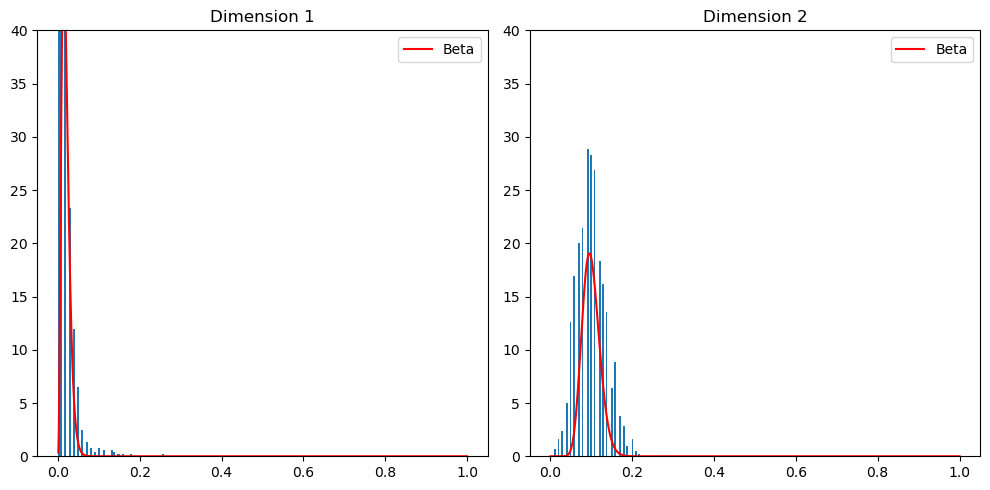

Iteration 200: Loss = -9570.3828125
Iteration 400: Loss = -9850.8076171875
probs_beta [[0.01391315 0.0845708 ]]


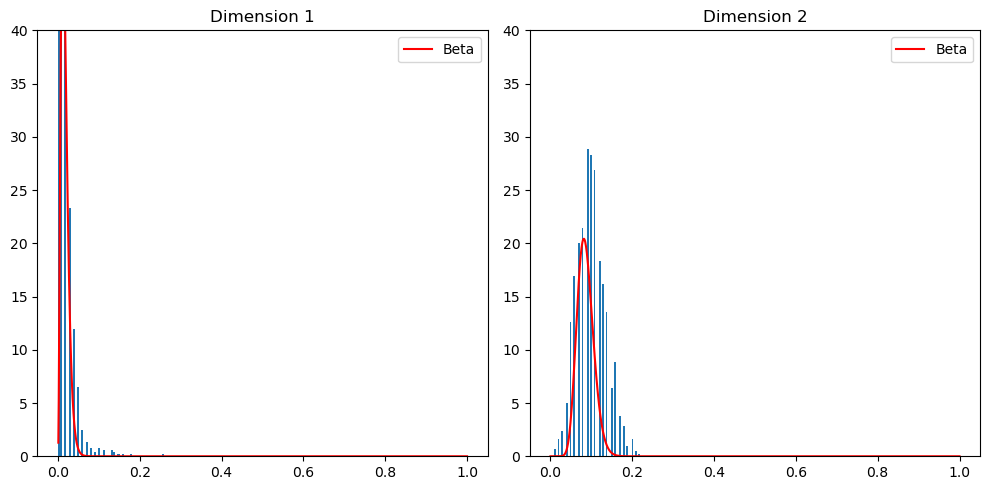

Iteration 600: Loss = -10806.8046875
Iteration 800: Loss = -12357.6357421875
probs_beta [[0.01201791 0.08133704]]


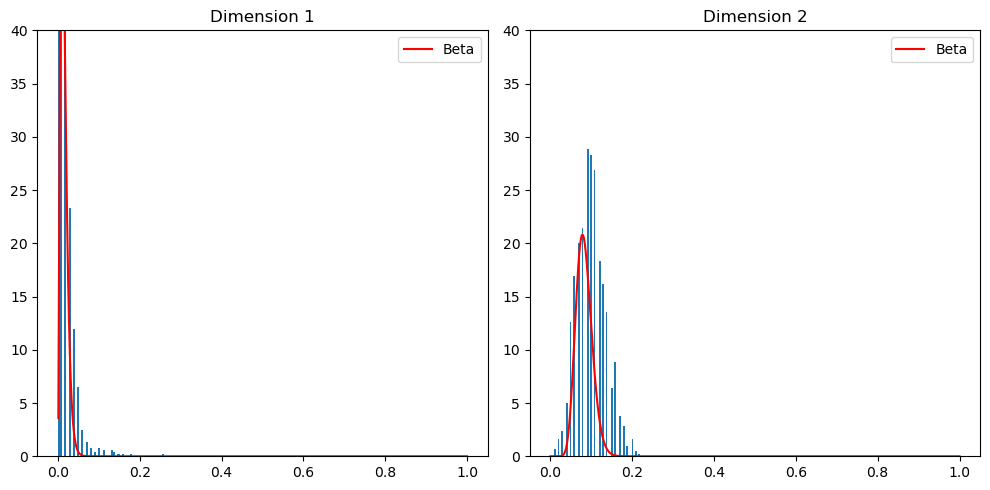

Iteration 1000: Loss = -13653.2646484375
Iteration 1200: Loss = -14716.564453125
probs_beta [[0.01188633 0.08077756]]


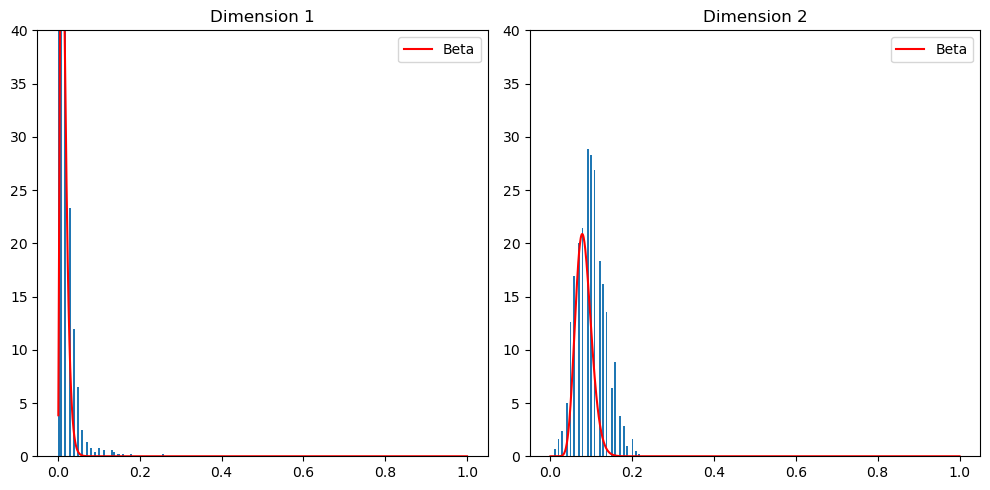

Iteration 1400: Loss = -15638.7177734375
Iteration 1600: Loss = -16472.775390625
probs_beta [[0.01186669 0.08075504]]


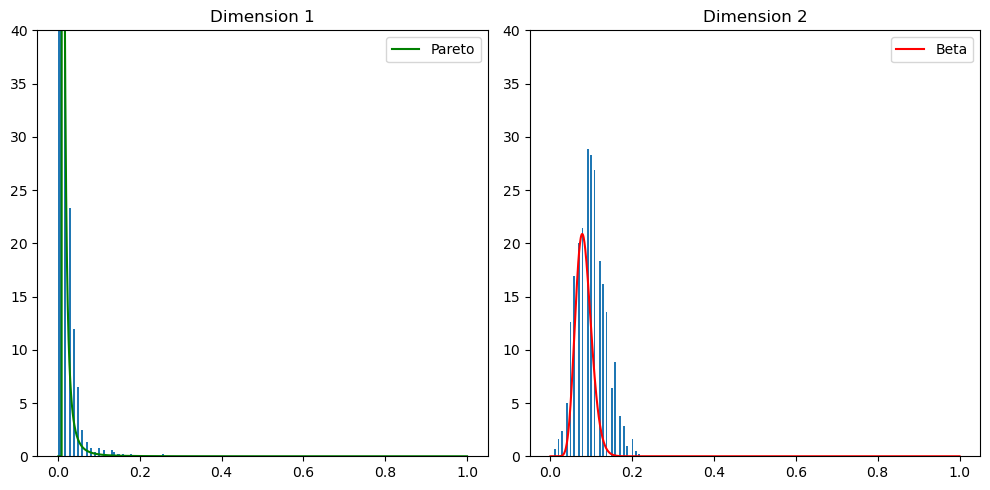

Iteration 1800: Loss = -17249.654296875
Iteration 2000: Loss = -17988.263671875
probs_beta [[0.01185704 0.08079376]]


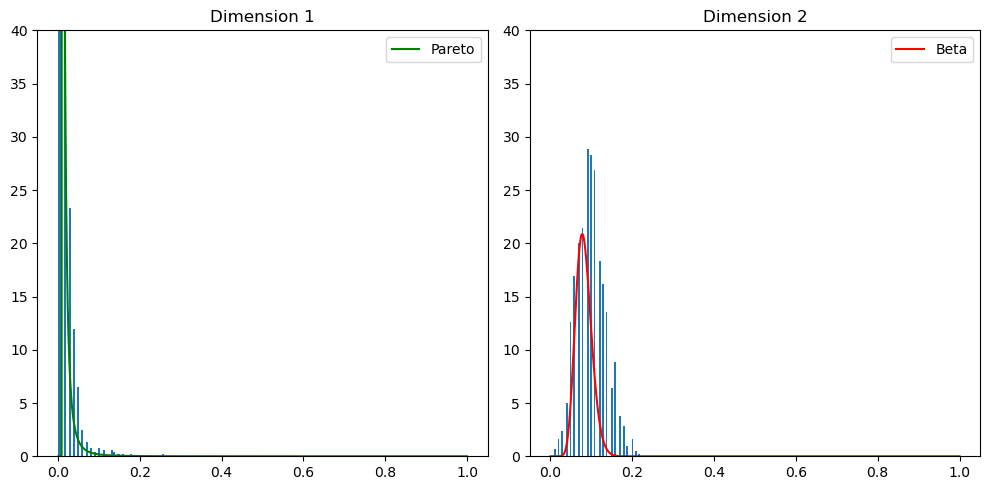

Iteration 2200: Loss = -18700.447265625
Iteration 2400: Loss = -19393.962890625
probs_beta [[0.0118471  0.08083712]]


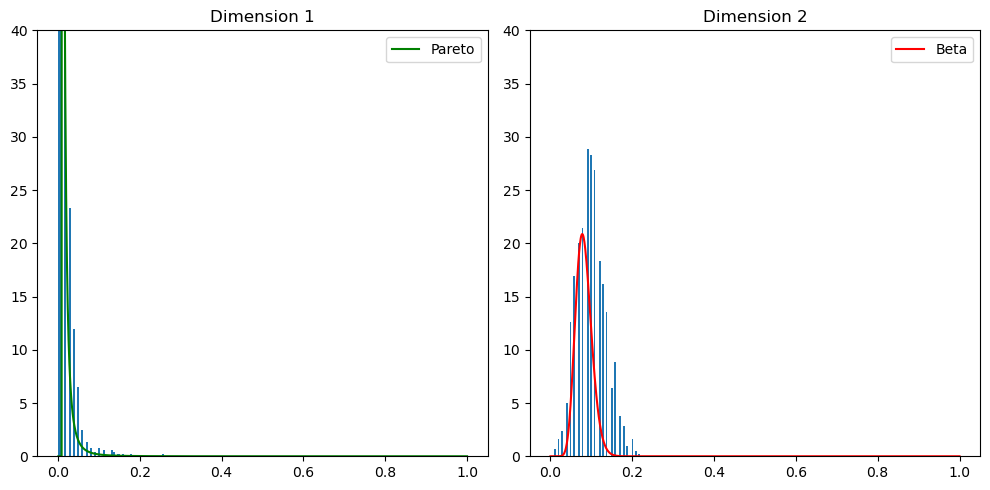

Iteration 2600: Loss = -20074.080078125
Iteration 2800: Loss = -20744.2578125
probs_beta [[0.01183521 0.08087308]]


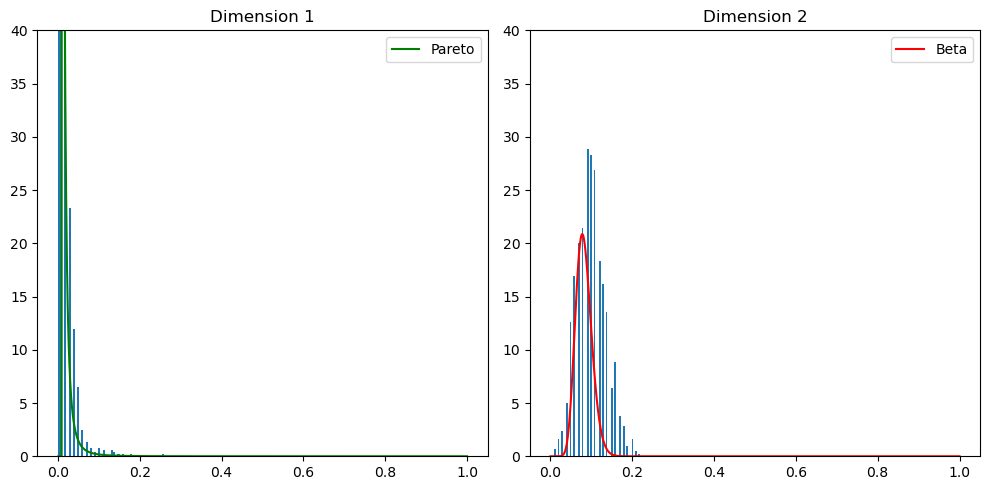

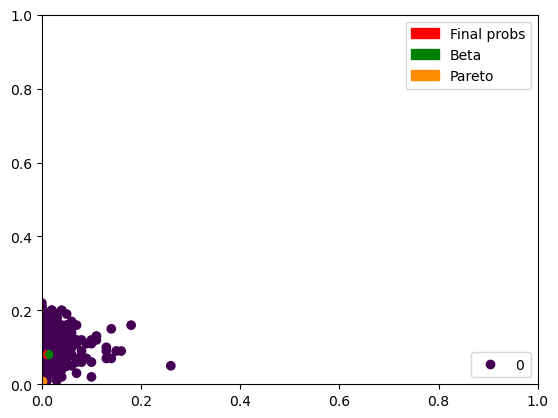

In [43]:
mb = mobster_MV(NV, DP, K = 1, seed = 153)
mb.fit(num_iter = 3000, lr = 0.001)

In [44]:
print(compute_likelihood(mb, beta = True, dim = 0, k = 0)) # x axis, beta
print(compute_likelihood(mb, beta = False, dim = 0, k = 0)) # x axis, pareto
print(compute_likelihood(mb, beta = True, dim = 1, k = 0)) # y axis, beta
print(compute_likelihood(mb, beta = False, dim = 1, k = 0)) # y axis, pareto

tensor(9.4345)
tensor(21.1137)
tensor(7.4563)
tensor(6.8646)


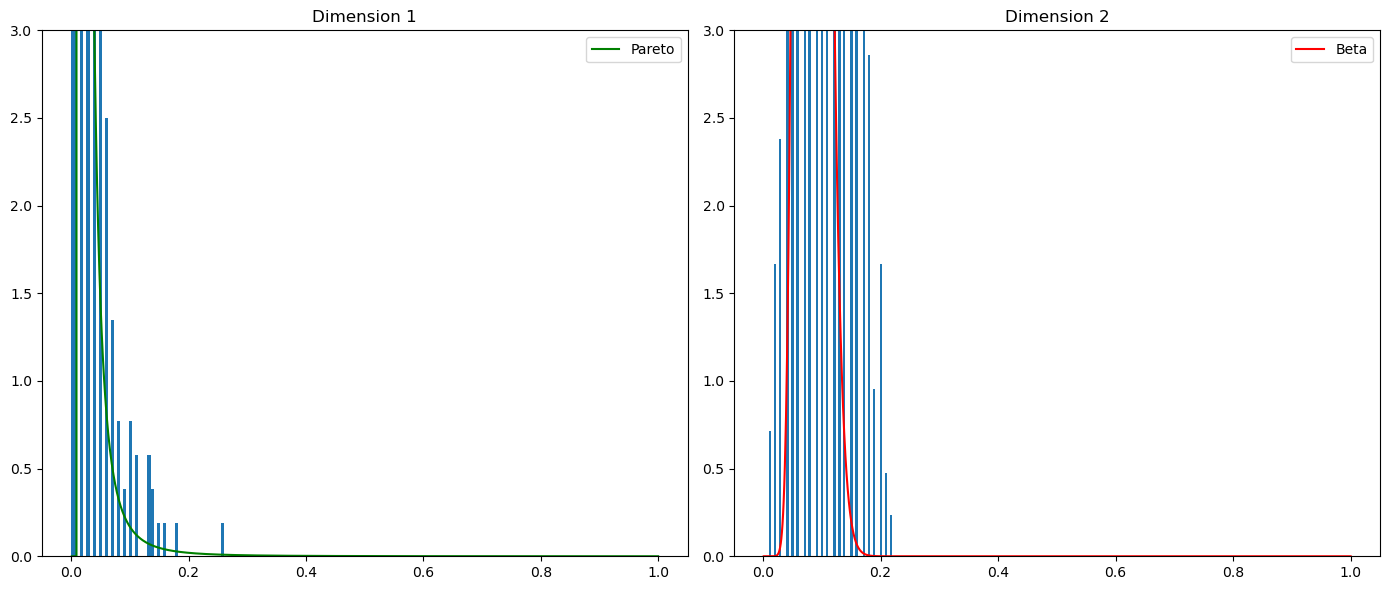

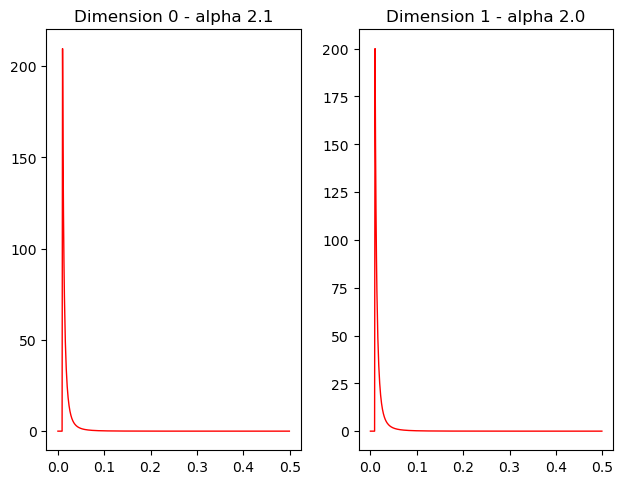

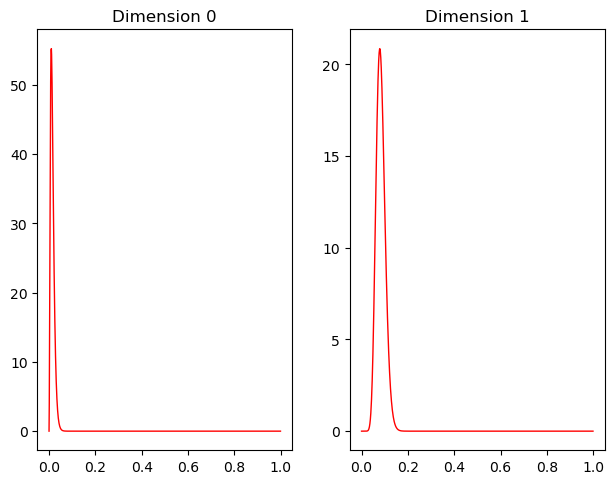

In [45]:
plot_marginals(mb)
# plot_deltas(mb)
plot_paretos_1(mb)
plot_betas_1(mb)

In [27]:
mb.params

{'probs_beta': tensor([[0.0133, 0.0808]]),
 'probs_pareto': tensor([[0.0007, 0.0093]]),
 'weights': tensor([1.]),
 'delta': tensor([[[0.9712, 0.0288],
          [0.0232, 0.9768]]]),
 'alpha_pareto': tensor([[2.0800, 2.0001]]),
 'phi_beta': tensor([[0.0161, 0.0829]]),
 'k_beta': tensor([[200.0007, 200.6188]]),
 'responsib': tensor([[0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
          0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
          0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
          0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
          0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
          0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
          0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
          0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
          0.0014, 0.

### 2 beta-pareto components

In [10]:
N1 = 1000
N2 = 500
seed = 123
# Sample S1
alpha_pareto = 2
L_pareto = 0.01
H_pareto = 0.3
phi_beta = 0.2
k_beta = 200
n1 = 100
NV1, DP1 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)

# Sample S2
phi_beta_x = 0.5
k_beta_x = 250
phi_beta_y = 0.5
k_beta_y= 250
n2=150
NV2, DP2 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n2, N=N2, seed=seed)
NV = torch.concat((NV1,NV2))
print(NV.shape)
DP = torch.concat((DP1,DP2))
print(DP.shape)

torch.Size([1500, 2])
torch.Size([1500, 2])


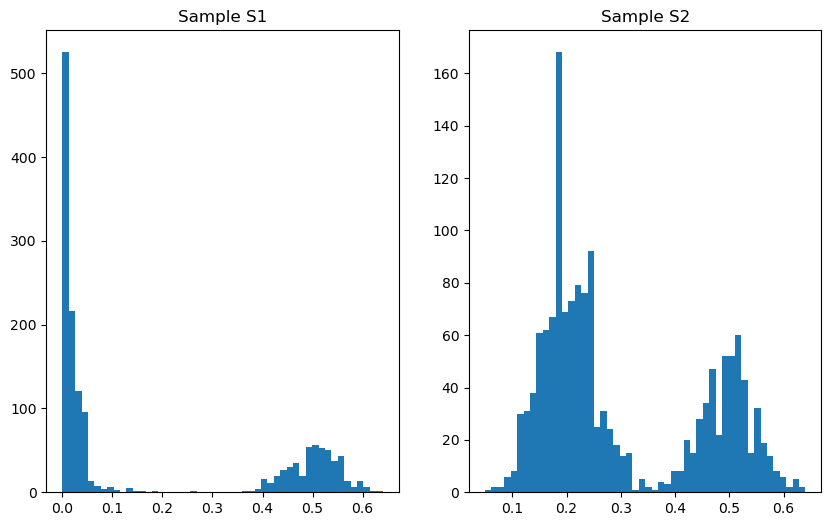

In [11]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Sample S2")
plt.show()

In [12]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels = np.concatenate((labels_1, labels_2))

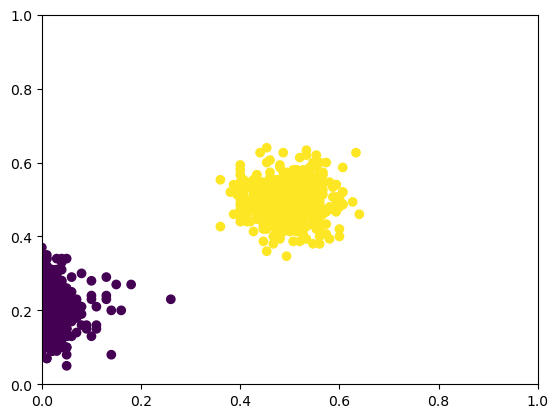

In [13]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[0.5020, 0.4978],
        [0.0191, 0.2010]])


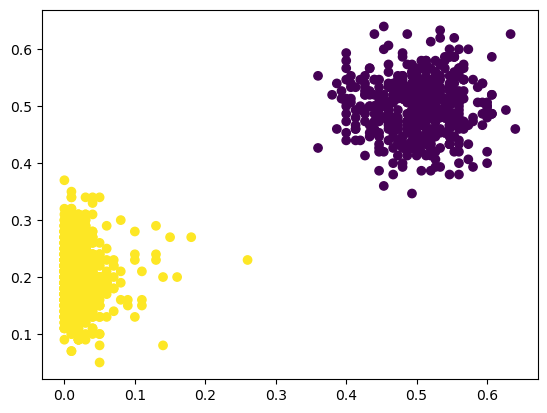

In [21]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=123, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)

kmeans_centers:  tensor([[0.5020, 0.4978],
        [0.0191, 0.2010]])
Iteration 0: Loss = 2351683.75
weights_param tensor([0.1330, 0.8670], grad_fn=<DivBackward0>)
delta_param tensor([[[0.2576, 0.7424],
         [0.4104, 0.5896]],

        [[0.3247, 0.6753],
         [0.1268, 0.8732]]], grad_fn=<DivBackward0>)
alpha_param tensor([[1.9980, 1.9980],
        [1.9980, 1.9980]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.5020, 0.4978],
        [0.0191, 0.2011]], grad_fn=<AddBackward0>)
k_beta_param tensor([[200.2001, 200.2001],
        [200.2001, 200.2001]], grad_fn=<AddBackward0>)
probs_beta_param tensor([[0.5020, 0.4978],
        [0.0190, 0.2009]], grad_fn=<AddBackward0>)
probs_pareto_param tensor([[0.5020, 0.4978],
        [0.0190, 0.2009]], grad_fn=<AddBackward0>)


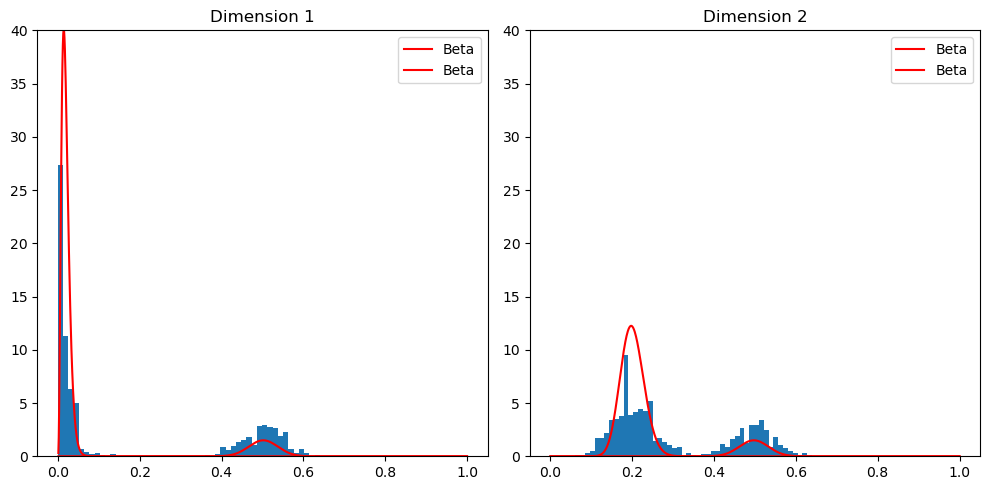

Iteration 200: Loss = 1260650.375
Iteration 400: Loss = -24037.2578125
probs_beta [[0.5016885  0.4974129 ]
 [0.01700932 0.19799113]]


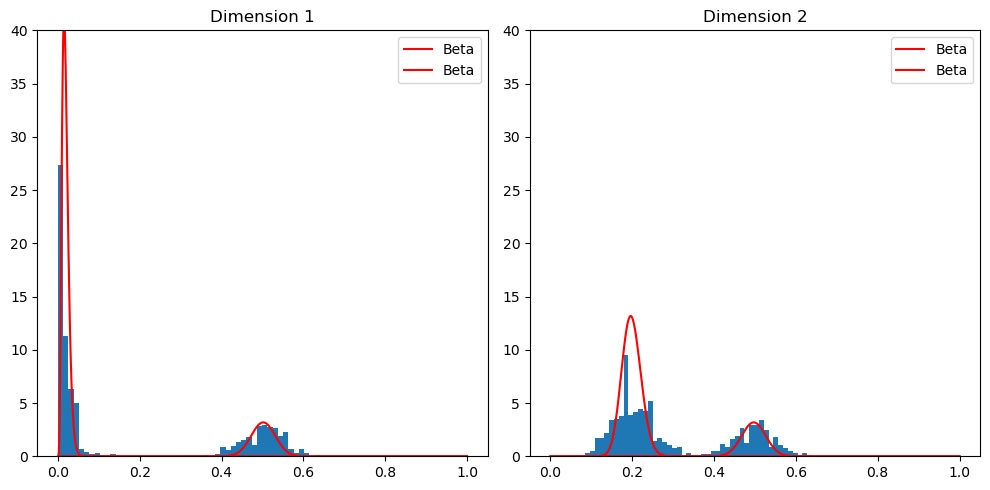

Iteration 600: Loss = -3215090.5
Iteration 800: Loss = -8712559.0
probs_beta [[0.5016892  0.49741325]
 [0.02427356 0.19838844]]


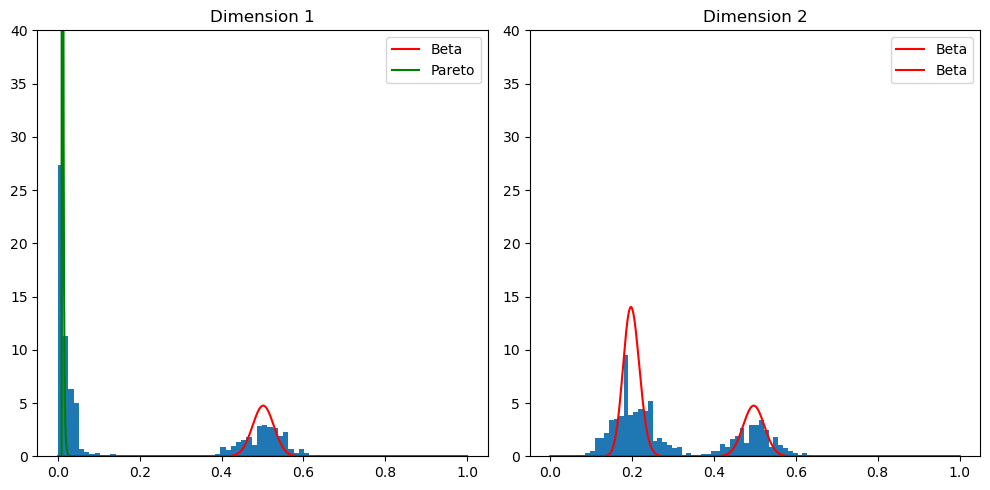

Iteration 1000: Loss = -18399468.0
Iteration 1200: Loss = -35763640.0
probs_beta [[0.50168926 0.49741358]
 [0.02972909 0.19833611]]


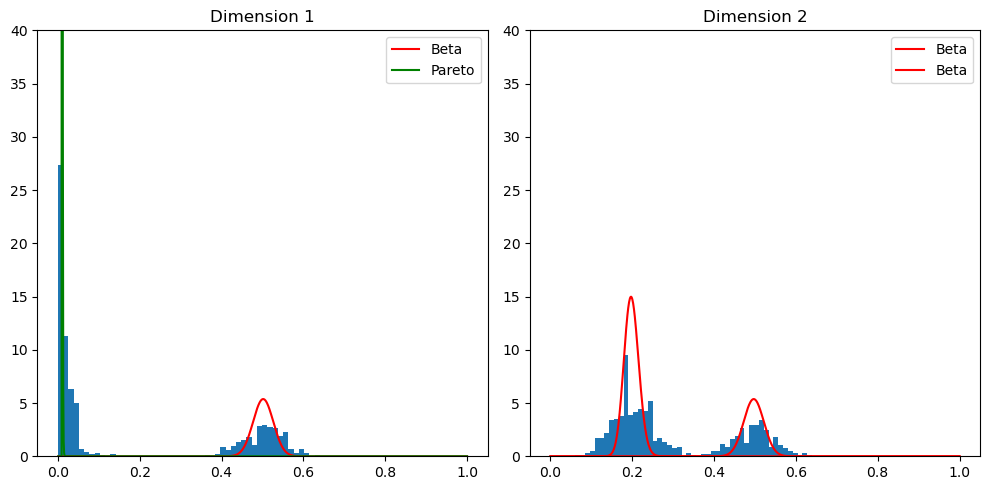

Iteration 1400: Loss = -65441872.0
Iteration 1600: Loss = -111314160.0
probs_beta [[0.5020111  0.49777535]
 [0.03014469 0.1983043 ]]


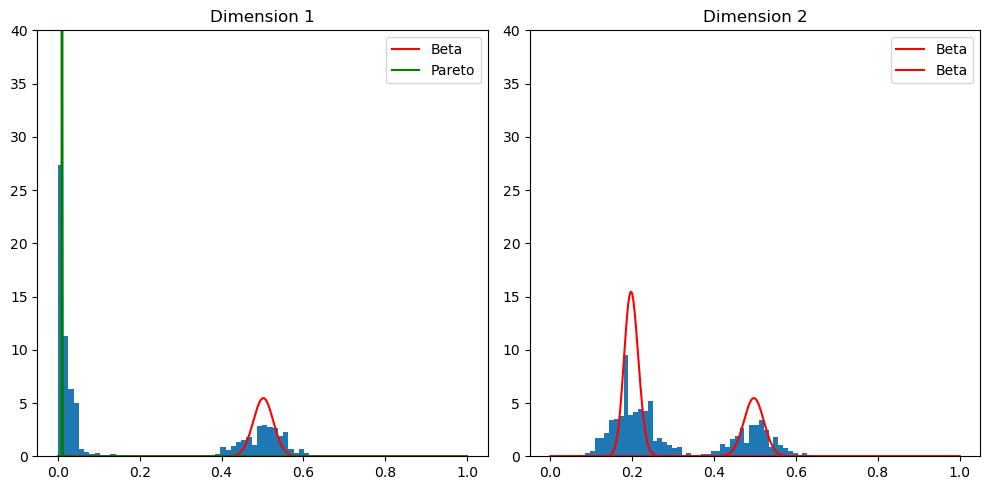

Iteration 1800: Loss = -173378304.0
Iteration 2000: Loss = -244565024.0
probs_beta [[0.50201464 0.49777937]
 [0.03014469 0.1982617 ]]


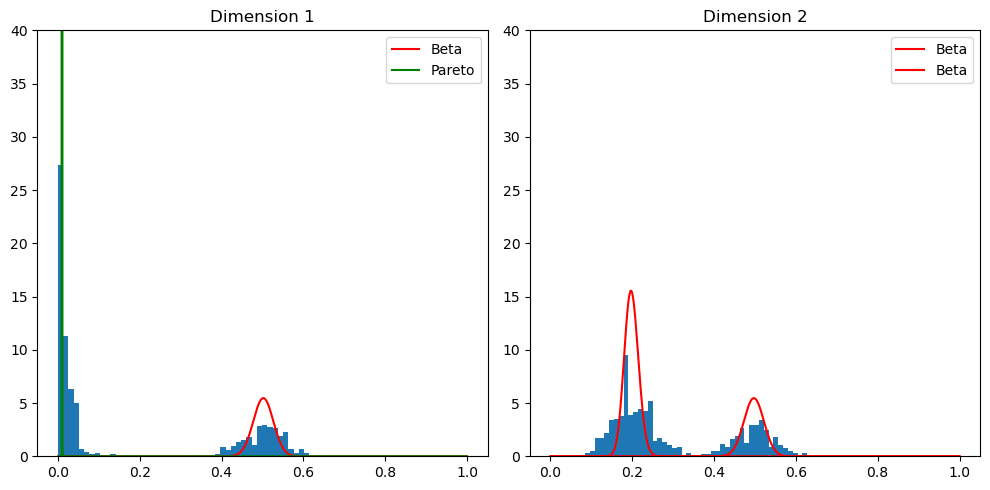

Iteration 2200: Loss = -316333920.0
Iteration 2400: Loss = -415328800.0
probs_beta [[0.507341   0.5018193 ]
 [0.03014469 0.27956054]]


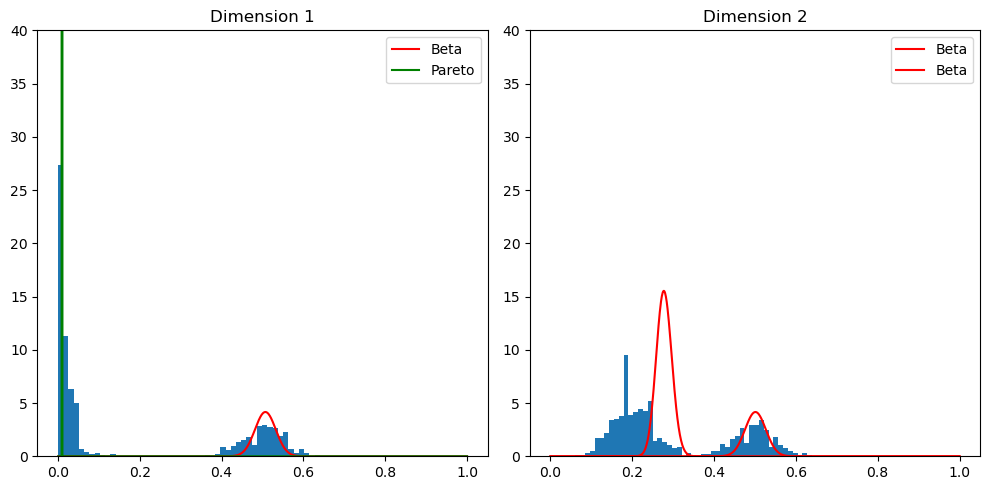

Iteration 2600: Loss = -675031936.0
Iteration 2800: Loss = -872662272.0
probs_beta [[0.5075985  0.50298154]
 [0.03014469 0.37722078]]


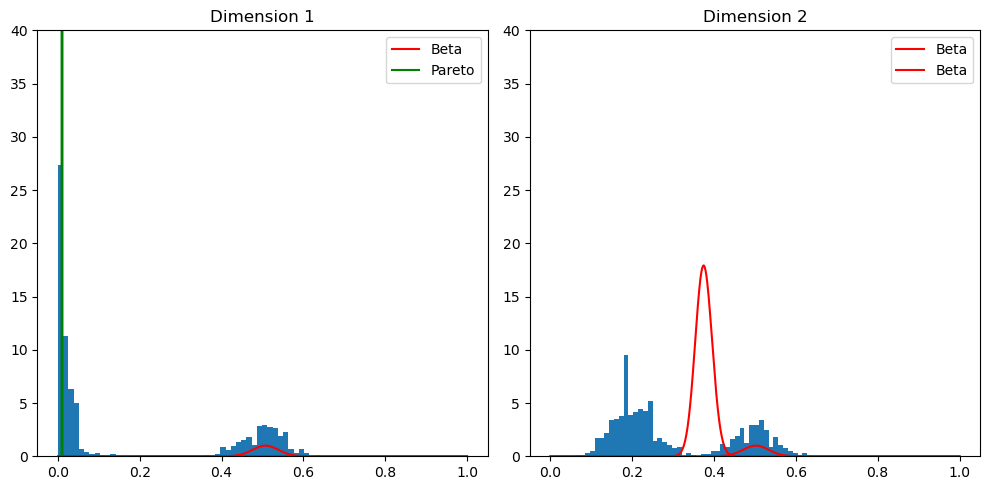

Iteration 3000: Loss = -1057699712.0
Iteration 3200: Loss = -1238327168.0
probs_beta [[0.5075985  0.50298154]
 [0.03014469 0.4244924 ]]


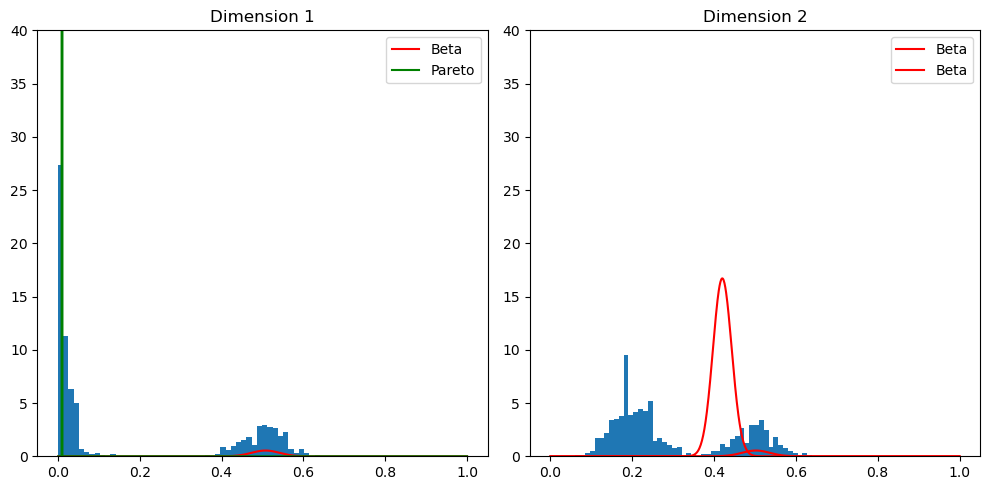

Iteration 3400: Loss = -1418291072.0
Iteration 3600: Loss = -1599727232.0
probs_beta [[0.5075985  0.50298154]
 [0.03014469 0.44590288]]


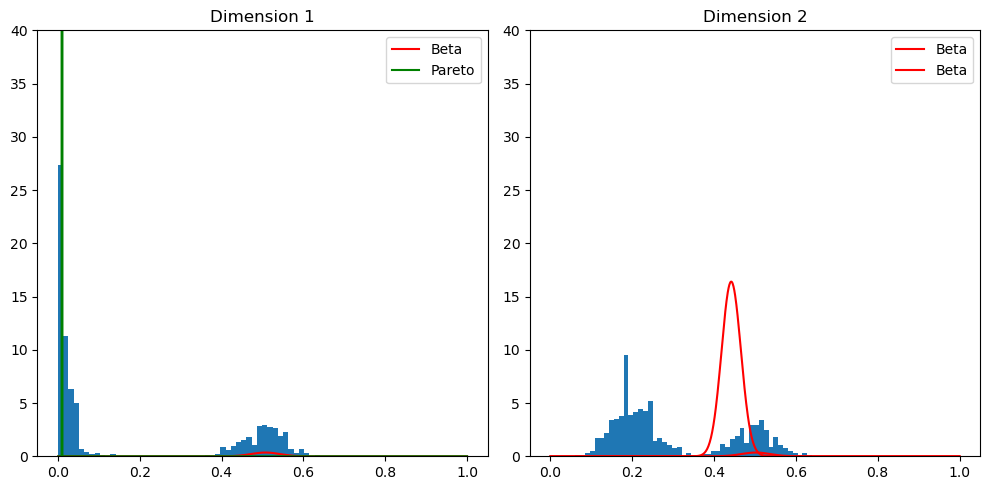

Iteration 3800: Loss = -1783919872.0
Iteration 4000: Loss = -1971678208.0
probs_beta [[0.5075985  0.50298154]
 [0.03014469 0.45791152]]


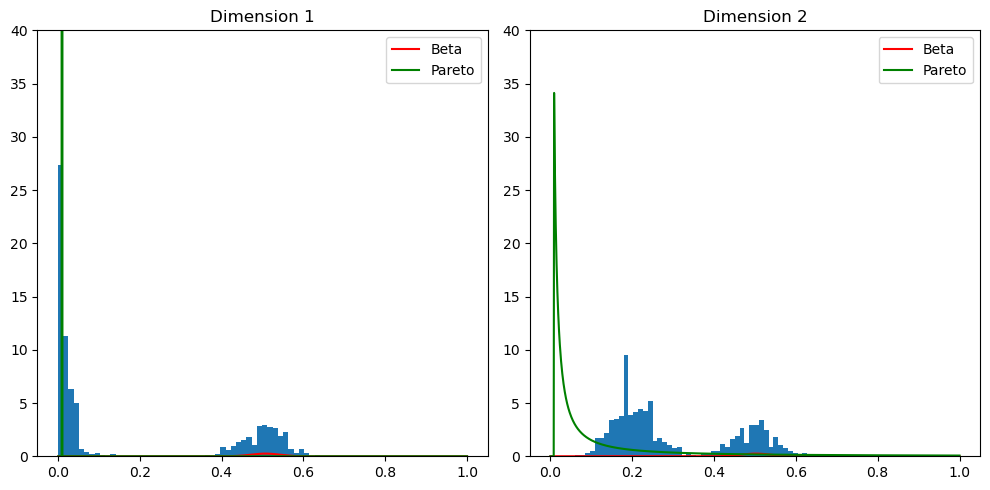

Iteration 4200: Loss = -2163542272.0
Iteration 4400: Loss = -2359887360.0
probs_beta [[0.5075985  0.50298154]
 [0.03014469 0.4658004 ]]


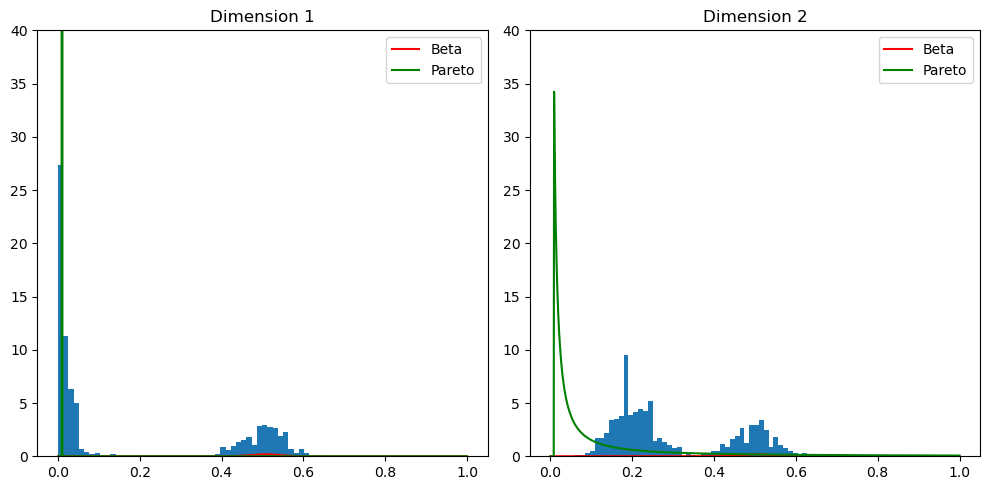

Iteration 4600: Loss = -2560989440.0
Iteration 4800: Loss = -2767032576.0
probs_beta [[0.5075985  0.50298154]
 [0.03014469 0.47145602]]


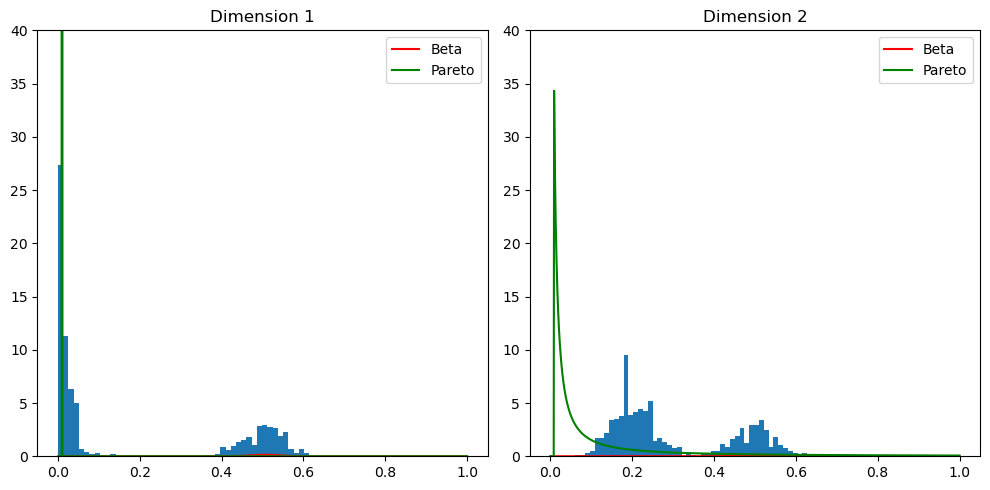

Iteration 5000: Loss = -2978165760.0
Iteration 5200: Loss = -3194496256.0
probs_beta [[0.5075985  0.50298154]
 [0.03014469 0.4757444 ]]


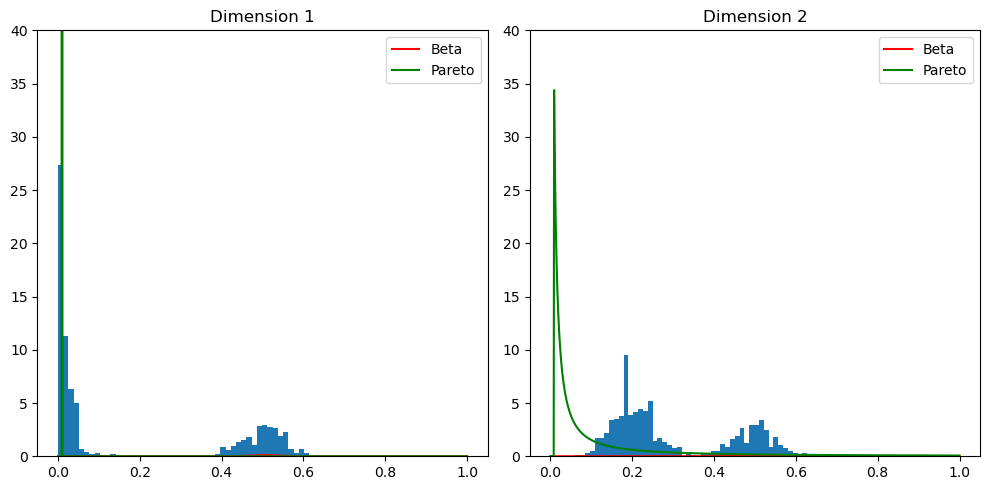

Iteration 5400: Loss = -3416106752.0
Iteration 5600: Loss = -3643060736.0
probs_beta [[0.5075985  0.50298154]
 [0.03014469 0.47912216]]


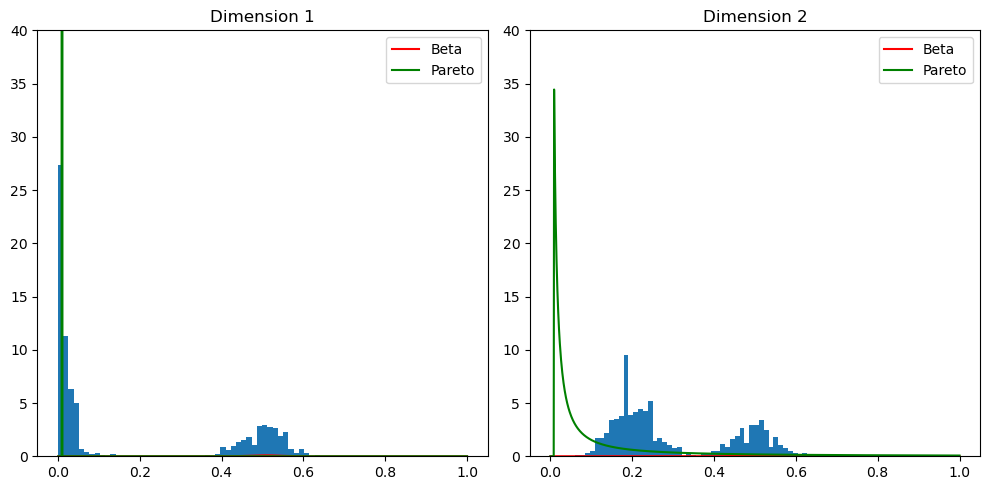

Iteration 5800: Loss = -3875400192.0
Iteration 6000: Loss = -4113164288.0
probs_beta [[0.5075985  0.50298154]
 [0.03014469 0.48185244]]


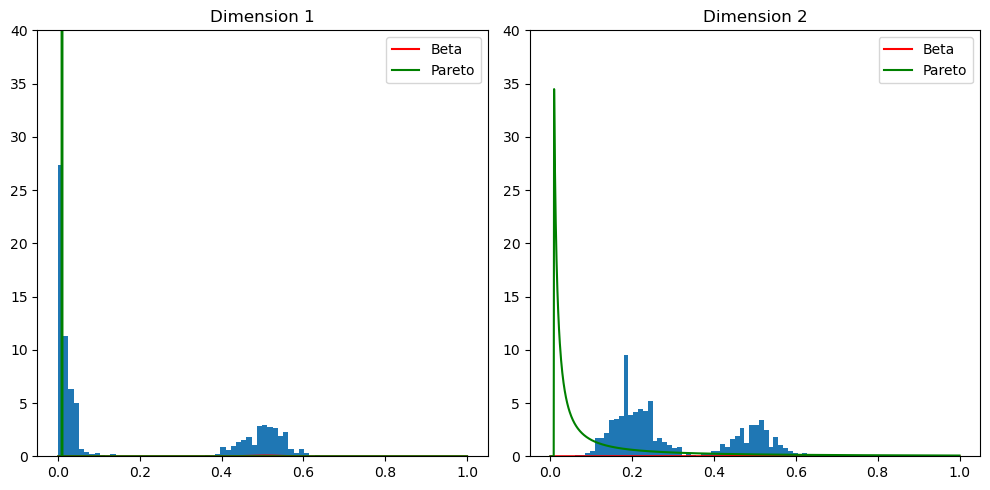

Iteration 6200: Loss = -4356373504.0
Iteration 6400: Loss = -4605046784.0
probs_beta [[0.5075985  0.50298154]
 [0.03014469 0.48409724]]


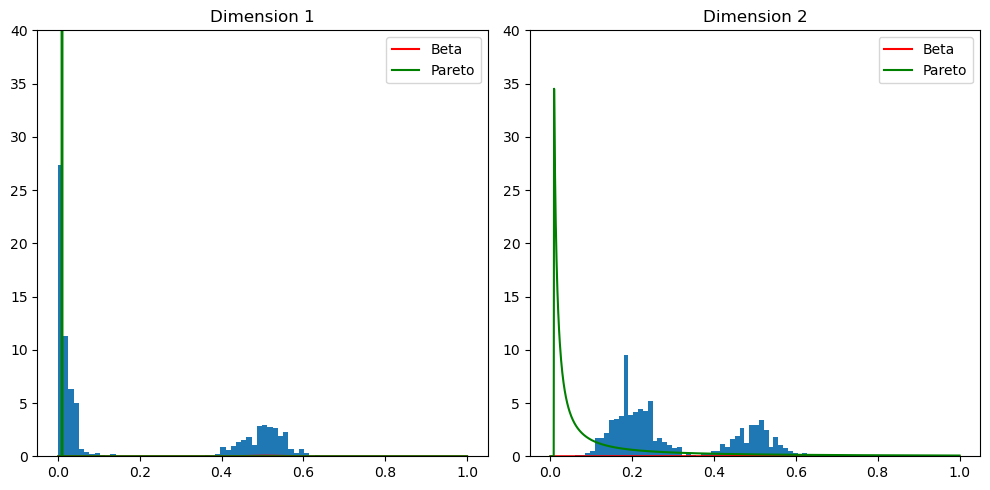

Iteration 6600: Loss = -4859196928.0
Iteration 6800: Loss = -5118838784.0
probs_beta [[0.5075985  0.50298154]
 [0.03014253 0.4859619 ]]


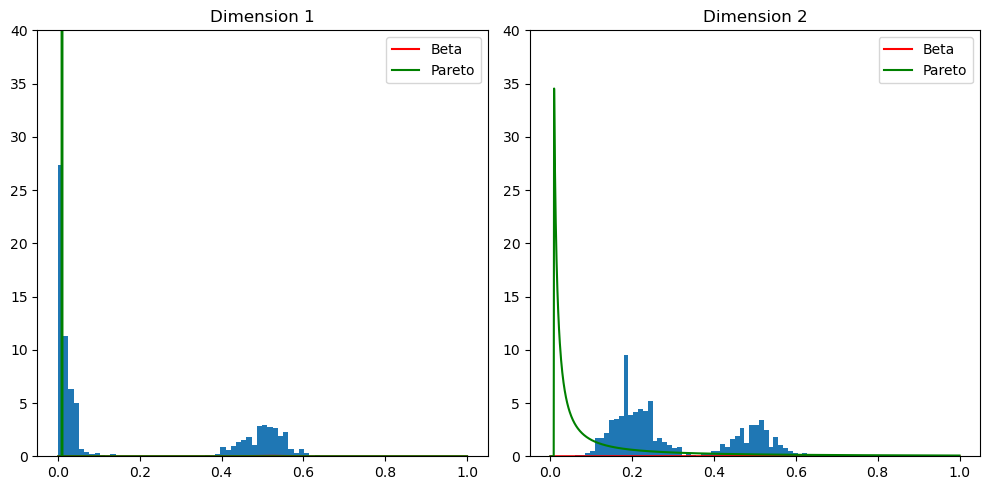

Iteration 7000: Loss = -5383968256.0
Iteration 7200: Loss = -5654595584.0
probs_beta [[0.5075985  0.50298154]
 [0.03013983 0.48751763]]


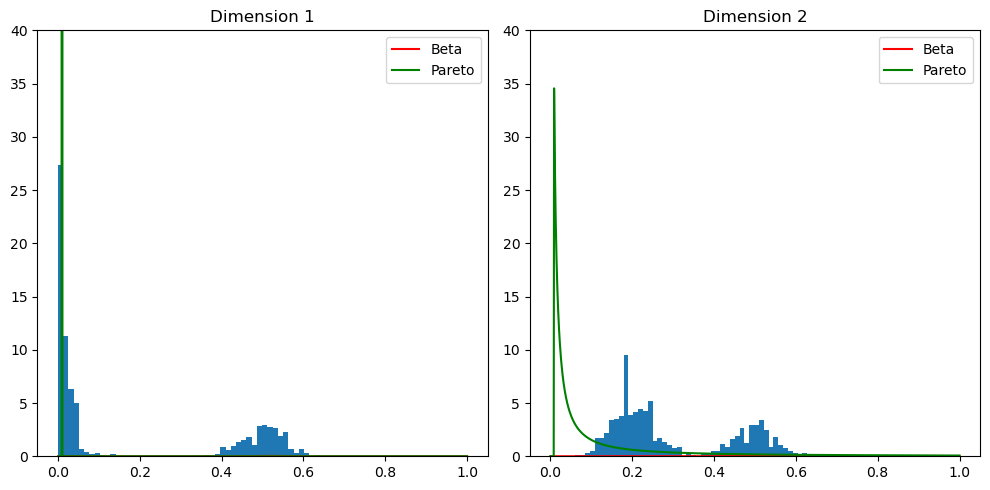

Iteration 7400: Loss = -5930720256.0
Iteration 7600: Loss = -6212336128.0
probs_beta [[0.5075985  0.50298154]
 [0.03013713 0.48881453]]


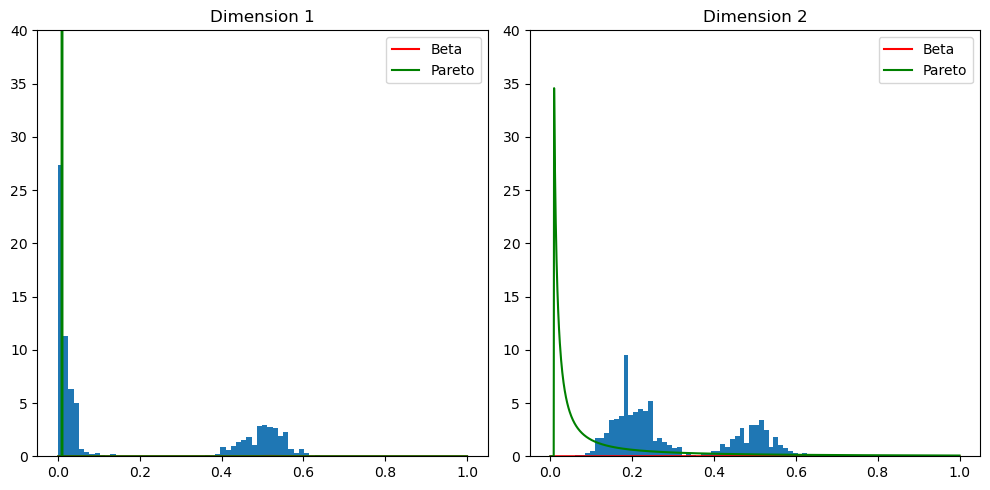

Iteration 7800: Loss = -6499453440.0
Iteration 8000: Loss = -6792050688.0
probs_beta [[0.5075985  0.50298154]
 [0.03013442 0.48988873]]


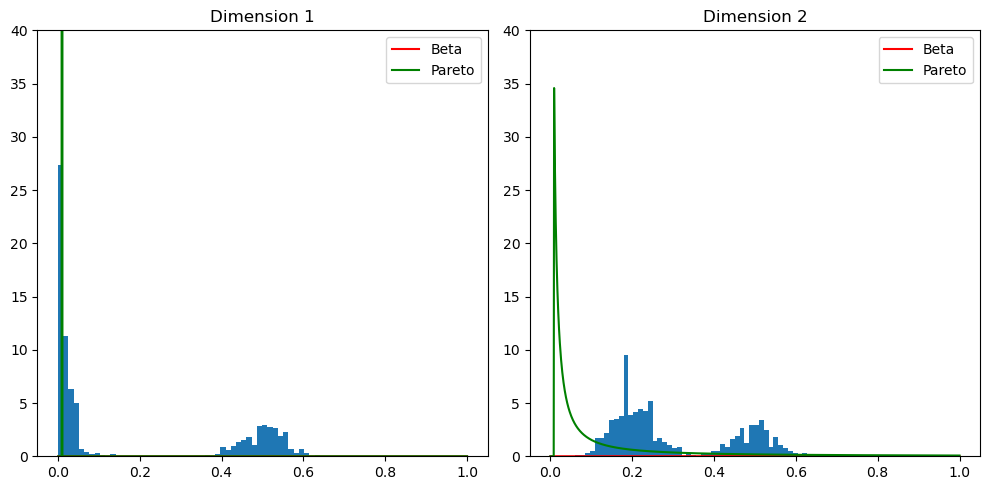

Iteration 8200: Loss = -7090143744.0
Iteration 8400: Loss = -7395368960.0
probs_beta [[0.5075985  0.50298154]
 [0.03013171 0.4907672 ]]


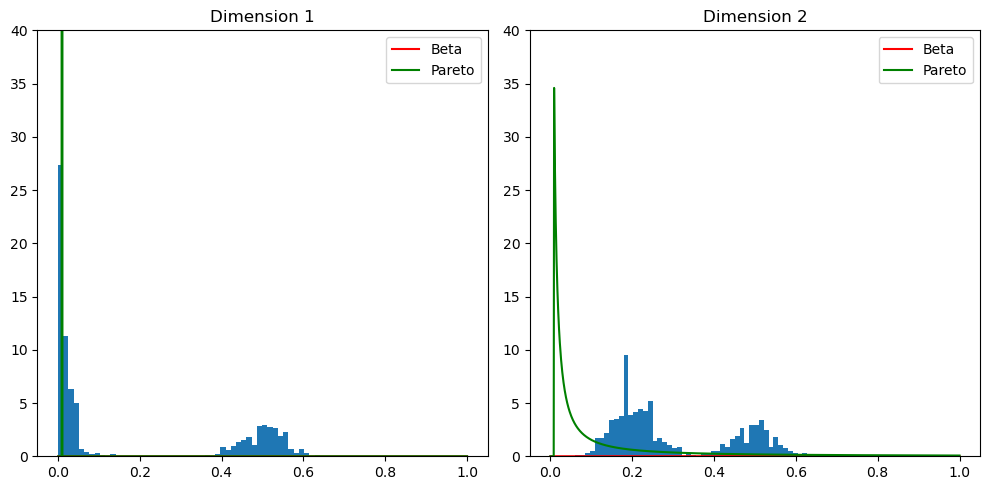

Iteration 8600: Loss = -7729447424.0
Iteration 8800: Loss = -8066686976.0
probs_beta [[0.5075985  0.50298154]
 [0.03012823 0.49147114]]


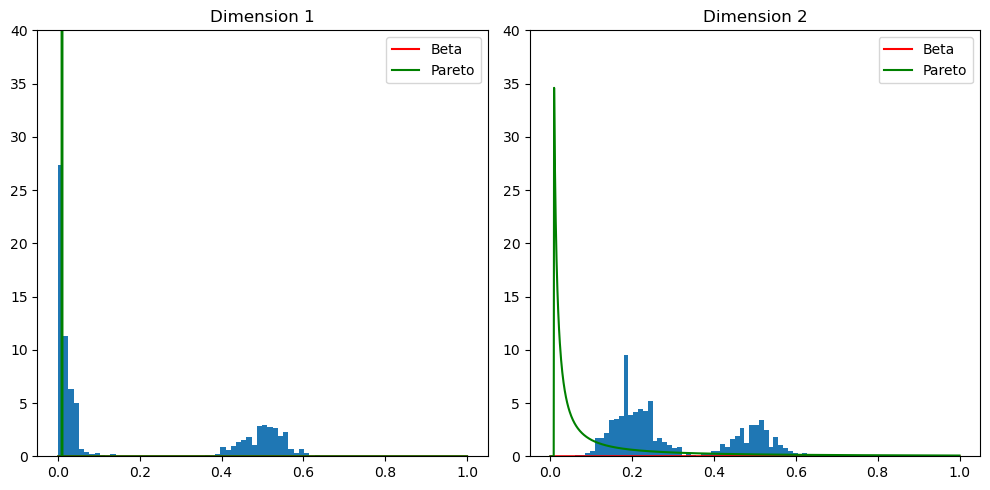

Iteration 9000: Loss = -8407470080.0
Iteration 9200: Loss = -8752166912.0
probs_beta [[0.5075985  0.50298154]
 [0.03012282 0.49201837]]


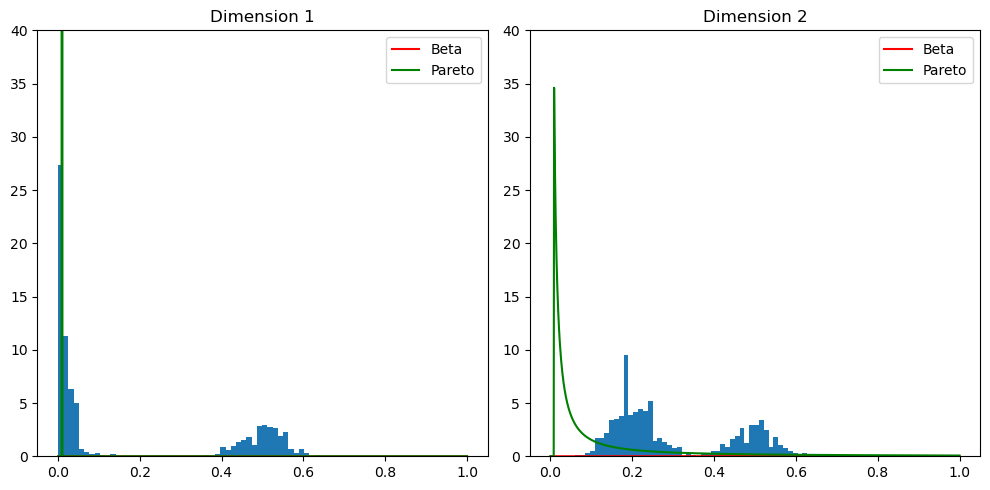

Iteration 9400: Loss = -9101084672.0
Iteration 9600: Loss = -9454469120.0
probs_beta [[0.5075985  0.50298154]
 [0.03011741 0.49242586]]


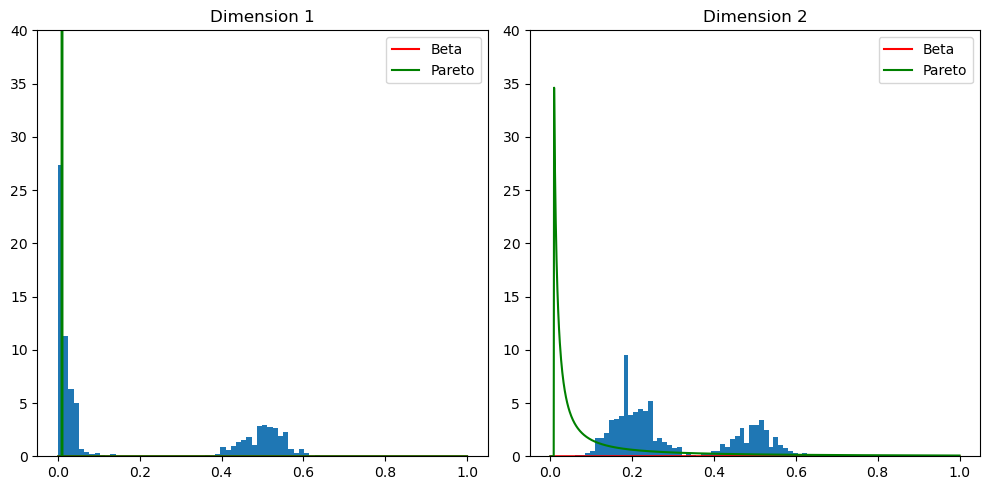

Iteration 9800: Loss = -9812446208.0


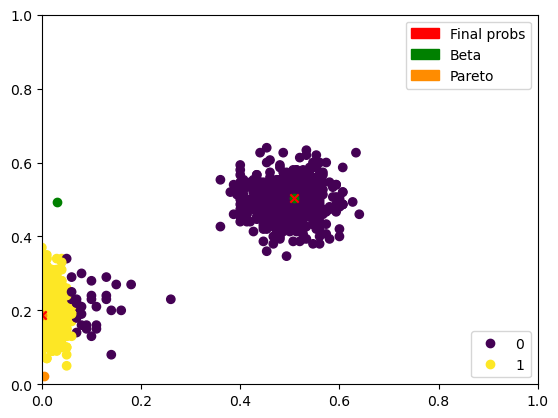

In [19]:
mb = mobster_MV(NV, DP, K = 2, seed = 45)
mb.fit(num_iter = 10000, lr = 0.001)

In [21]:
# Non va fatto così perchè sto passando ogni volta la mixture delle due componenti, non solo una o l'altra
"""
print(compute_likelihood(mb, beta = True, dim = 0, k = 0)) # x axis, beta
print(compute_likelihood(mb, beta = False, dim = 0, k = 0)) # x axis, pareto
print(compute_likelihood(mb, beta = True, dim = 1, k = 0)) # y axis, beta
print(compute_likelihood(mb, beta = False, dim = 1, k = 0)) # y axis, pareto

print(compute_likelihood(mb, beta = True, dim = 0, k = 1)) # x axis, beta
print(compute_likelihood(mb, beta = False, dim = 0, k = 1)) # x axis, pareto
print(compute_likelihood(mb, beta = True, dim = 1, k = 1)) # y axis, beta
print(compute_likelihood(mb, beta = False, dim = 1, k = 1)) # y axis, pareto
"""

'\nprint(compute_likelihood(mb, beta = True, dim = 0, k = 0)) # x axis, beta\nprint(compute_likelihood(mb, beta = False, dim = 0, k = 0)) # x axis, pareto\nprint(compute_likelihood(mb, beta = True, dim = 1, k = 0)) # y axis, beta\nprint(compute_likelihood(mb, beta = False, dim = 1, k = 0)) # y axis, pareto\n\nprint(compute_likelihood(mb, beta = True, dim = 0, k = 1)) # x axis, beta\nprint(compute_likelihood(mb, beta = False, dim = 0, k = 1)) # x axis, pareto\nprint(compute_likelihood(mb, beta = True, dim = 1, k = 1)) # y axis, beta\nprint(compute_likelihood(mb, beta = False, dim = 1, k = 1)) # y axis, pareto\n'

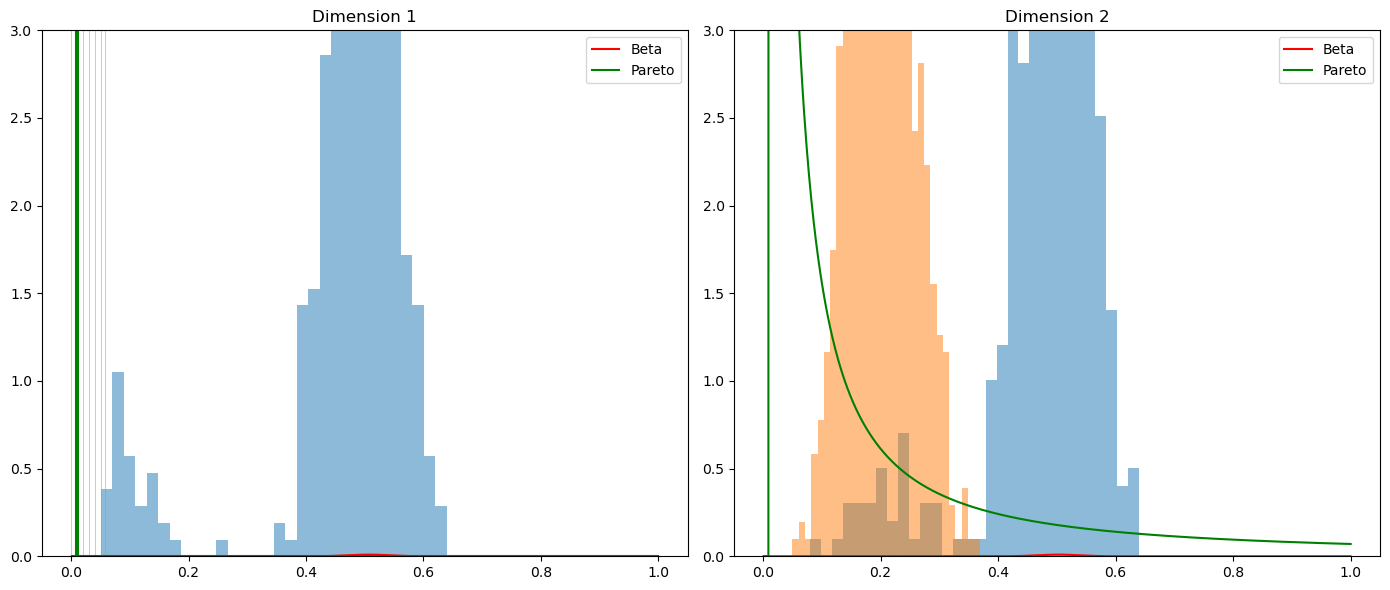

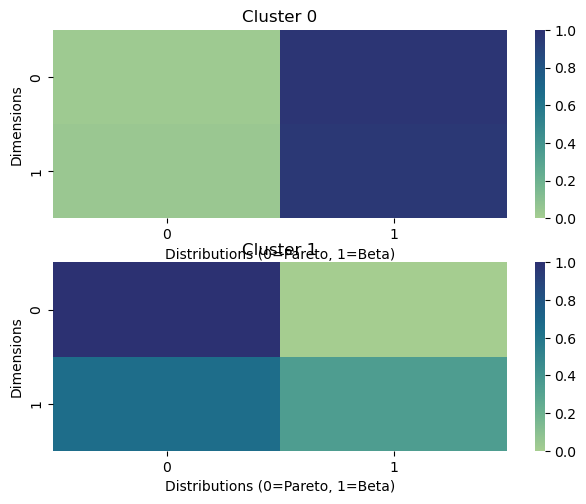

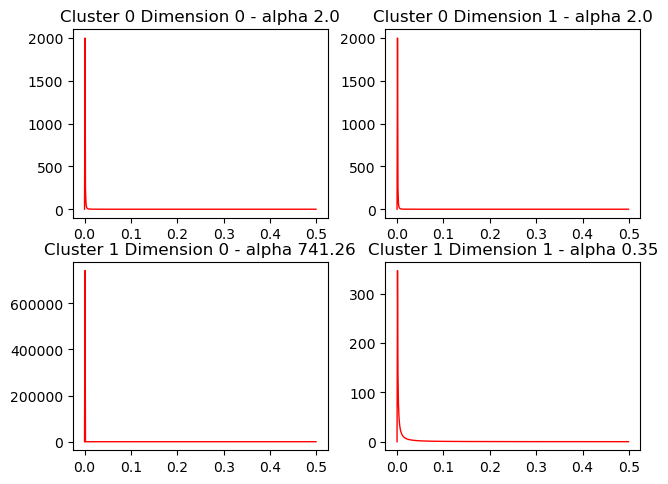

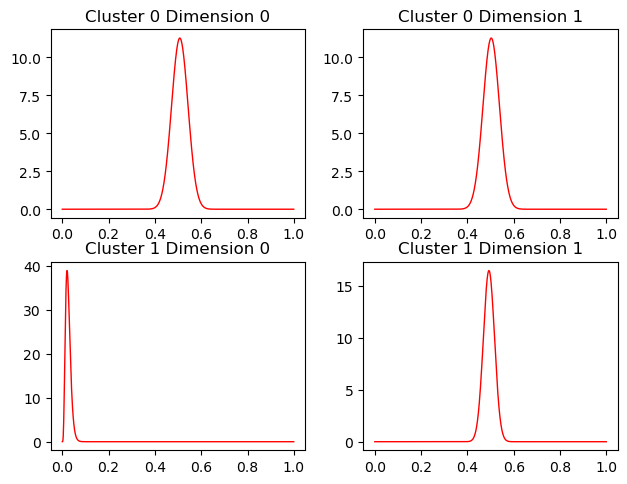

In [22]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

In [23]:
mb.params

{'probs_beta': tensor([[0.5020, 0.4978],
         [0.0301, 0.1983]]),
 'probs_pareto': tensor([[0.4228, 0.3612],
         [0.0005, 0.0400]]),
 'weights': tensor([0.3333, 0.6667]),
 'delta': tensor([[[0.0311, 0.9689],
          [0.0555, 0.9445]],
 
         [[0.9294, 0.0706],
          [0.0150, 0.9850]]]),
 'alpha_pareto': tensor([[ 1.9992,  1.9967],
         [92.3921,  1.9361]]),
 'phi_beta': tensor([[0.5020, 0.4978],
         [0.0253, 0.1988]]),
 'k_beta': tensor([[422.2708, 422.2689],
         [218.3892, 543.4517]]),
 'responsib': tensor([[9.9548e-38, 2.5691e-35, 1.3650e-30,  ..., 1.0000e+00, 1.0000e+00,
          1.0000e+00],
         [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]]),
 'cluster_assignments': tensor([1, 1, 1,  ..., 0, 0, 0])}

### 3 beta-pareto components

In [4]:
N1 = 500
N2 = 300
N3 = 200
N4 = 200
seed = 123
# Component 1
alpha_pareto = 2
L_pareto = 0.01
H_pareto = 0.3
phi_beta = 0.5
k_beta = 200
n1 = 100
NV1, DP1 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)

# Component 2
phi_beta_x = 0.5
k_beta_x = 250
phi_beta_y = 0.5
k_beta_y= 250
n2=150
NV2, DP2 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n2, N=N2, seed=seed)
NV = torch.concat((NV1,NV2))
DP = torch.concat((DP1,DP2))

# Component 3
phi_beta_x = 0.5
k_beta_x = 250
phi_beta_y = 0.0001
k_beta_y= 250
n3=150
NV3, DP3 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n3, N=N3, seed=seed)
NV = torch.concat((NV,NV3))
DP = torch.concat((DP,DP3))

# Component 4
phi_beta_x = 0.3
k_beta_x = 250
phi_beta_y = 0.0001
k_beta_y= 250
n3=150
NV4, DP4 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n3, N=N3, seed=seed)
NV = torch.concat((NV,NV4))
print(NV.shape)
DP = torch.concat((DP,DP4))
print(DP.shape)

torch.Size([1200, 2])
torch.Size([1200, 2])


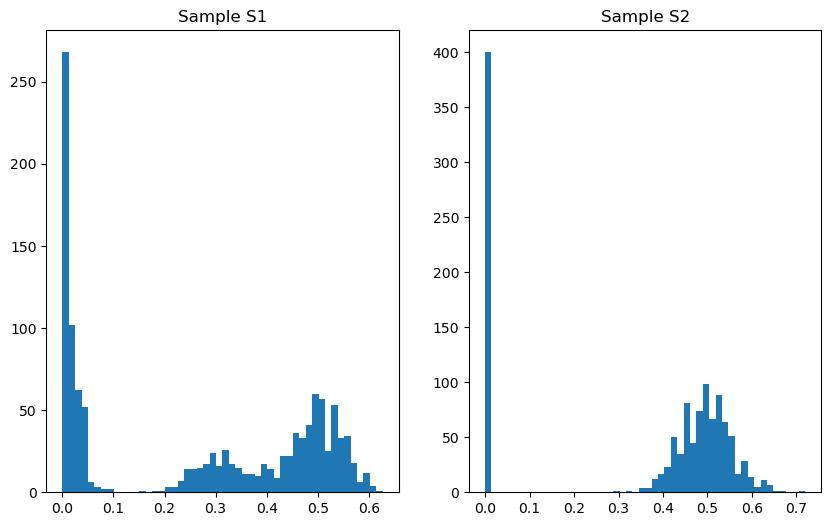

In [5]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Sample S2")
plt.show()

In [6]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels = np.concatenate((labels_1, labels_2))
labels_3 = np.ones(N3)*2
labels = np.concatenate((labels, labels_3))
labels_4 = np.ones(N3)*3
labels = np.concatenate((labels, labels_4))

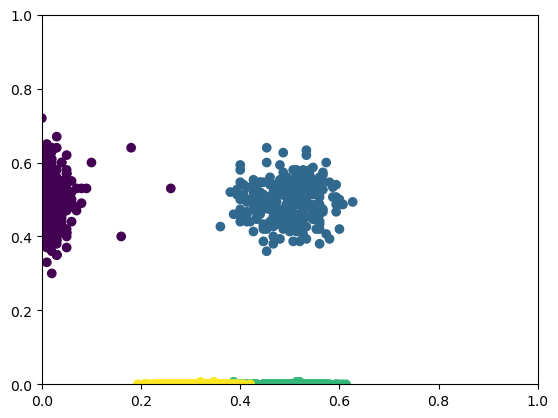

In [7]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[3.9953e-01, 8.3268e-05],
        [1.7890e-02, 5.3844e-01],
        [4.9825e-01, 4.9501e-01],
        [1.8333e-02, 4.4033e-01]])
Iteration 0: Loss = -2657547.25
weights_param tensor([0.0354, 0.2310, 0.1896, 0.5441], grad_fn=<DivBackward0>)
delta_param tensor([[[0.4104, 0.5896],
         [0.3256, 0.6744]],

        [[0.1268, 0.8732],
         [0.1612, 0.8388]],

        [[0.9419, 0.0581],
         [0.1642, 0.8358]],

        [[0.8597, 0.1403],
         [0.5829, 0.4171]]], grad_fn=<DivBackward0>)
alpha_param tensor([[1.9980, 2.0020],
        [1.9980, 1.9980],
        [1.9980, 1.9980],
        [1.9980, 1.9980]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[3.9962e-01, 8.3351e-05],
        [1.7907e-02, 5.1000e-01],
        [4.9826e-01, 4.9502e-01],
        [1.8351e-02, 4.4039e-01]], grad_fn=<AddBackward0>)
k_beta_param tensor([[200.2001, 200.2001],
        [200.2001, 200.2001],
        [200.2001, 200.2001],
        [200.2001, 200.2001]], grad_fn=<AddBackward0>)


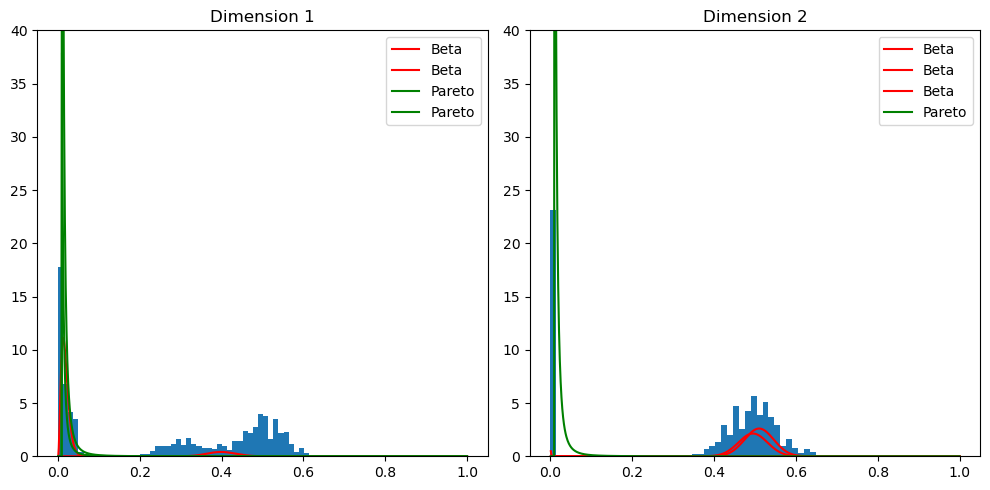

Iteration 200: Loss = -5133281.5
Iteration 400: Loss = -8303208.5
probs_beta [[4.1723195e-01 5.8016514e-05]
 [1.5730135e-02 5.0999993e-01]
 [4.9782729e-01 4.9524286e-01]
 [1.8644471e-02 4.6268135e-01]]


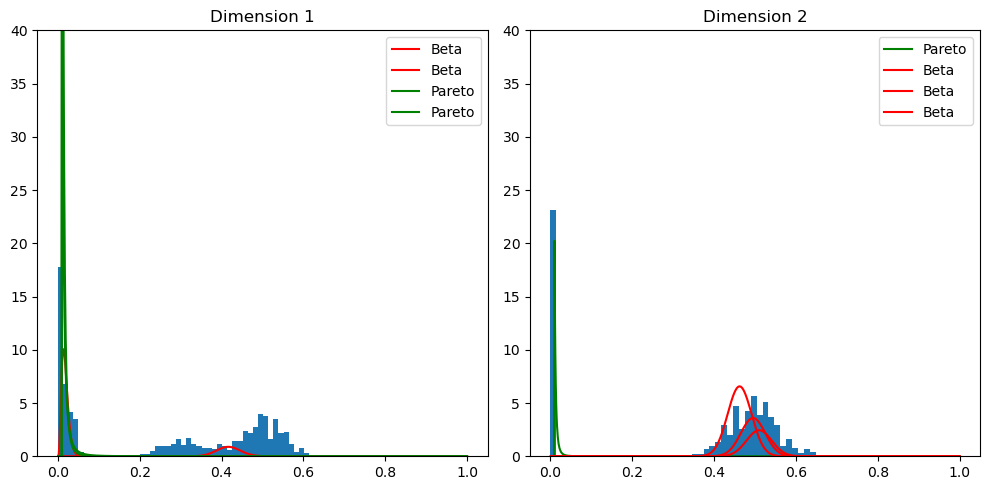

Iteration 600: Loss = -12744981.0
Iteration 800: Loss = -19145572.0
probs_beta [[4.4602215e-01 3.9832750e-05]
 [1.7774682e-02 5.0999993e-01]
 [4.9849471e-01 4.9494135e-01]
 [3.3664908e-02 4.8028007e-01]]


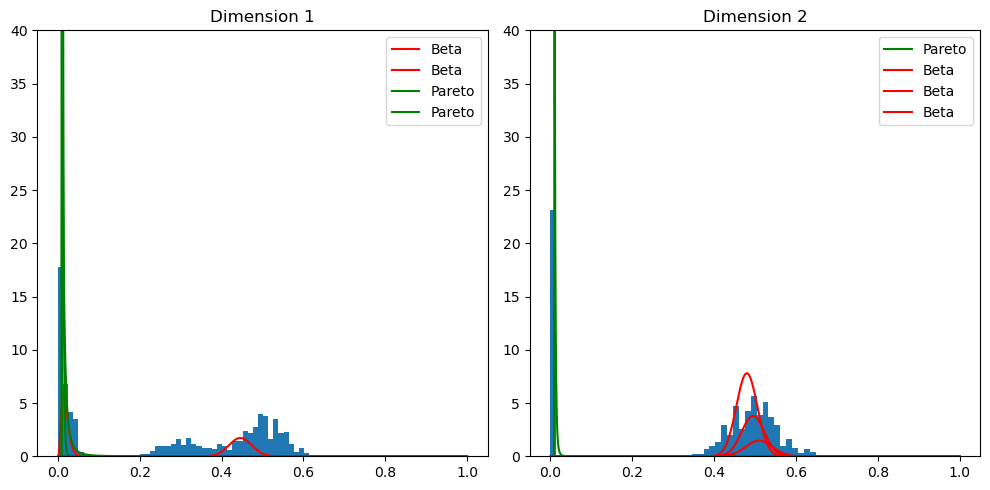

Iteration 1000: Loss = -28508374.0
Iteration 1200: Loss = -42140040.0
probs_beta [[4.5784661e-01 2.7141388e-05]
 [1.7884741e-02 5.0999993e-01]
 [4.9851176e-01 4.9493432e-01]
 [4.8314214e-02 4.8721105e-01]]


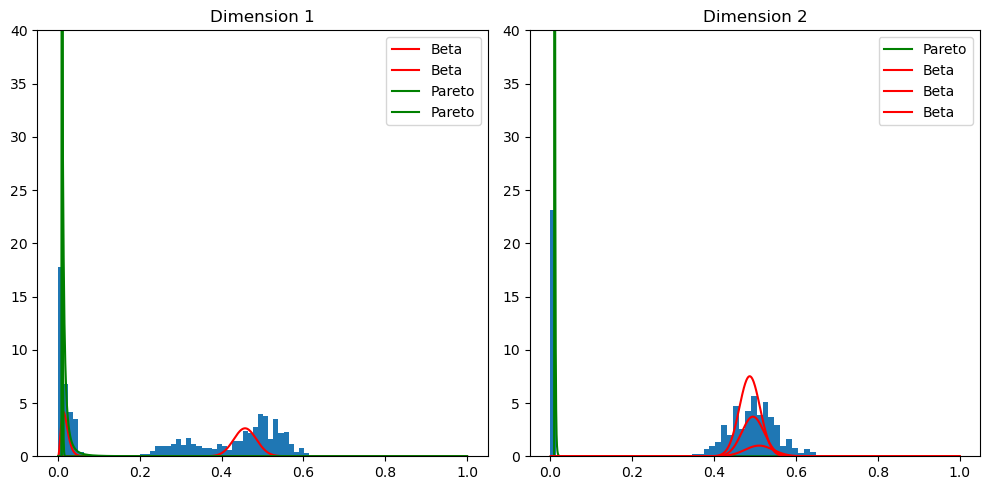

Iteration 1400: Loss = -61362448.0
Iteration 1600: Loss = -87607992.0
probs_beta [[4.6642789e-01 1.8477016e-05]
 [1.7884741e-02 5.0999993e-01]
 [4.9851134e-01 4.9493444e-01]
 [5.6826077e-02 4.9069855e-01]]


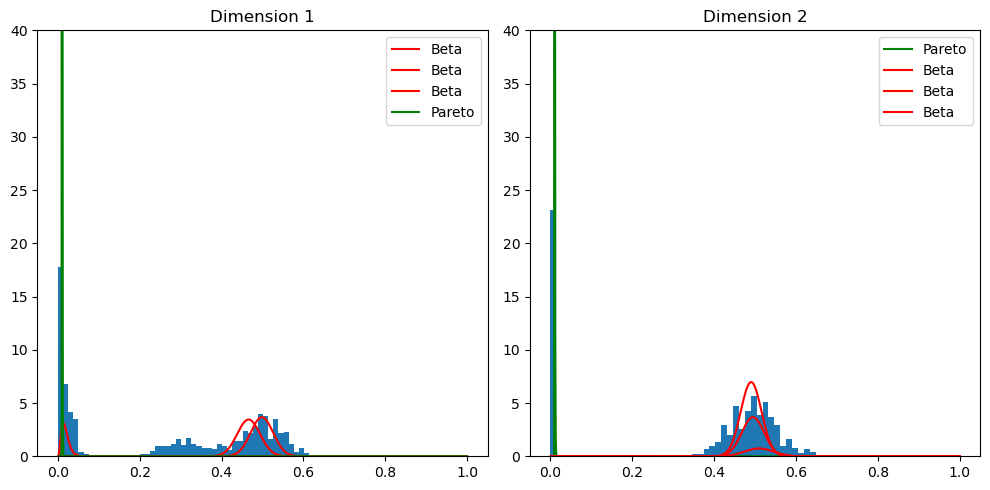

Iteration 1800: Loss = -122234032.0
Iteration 2000: Loss = -165418128.0
probs_beta [[4.7085309e-01 1.2601446e-05]
 [1.7884741e-02 5.0999993e-01]
 [4.9884984e-01 4.9488512e-01]
 [5.6826077e-02 4.9286613e-01]]


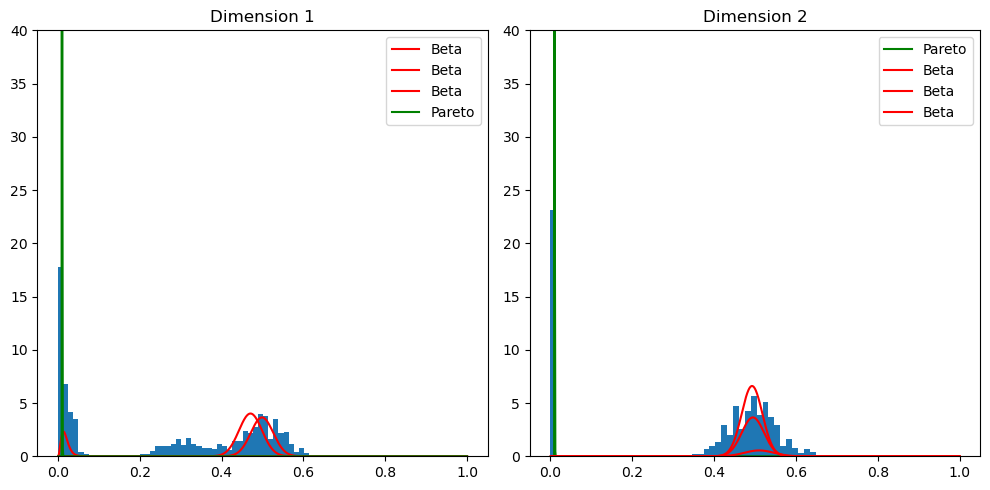

Iteration 2200: Loss = -214075680.0
Iteration 2400: Loss = -268341312.0
probs_beta [[4.6837845e-01 8.6162700e-06]
 [1.7884741e-02 5.0999993e-01]
 [4.9883780e-01 4.9806255e-01]
 [5.6821514e-02 4.9496892e-01]]


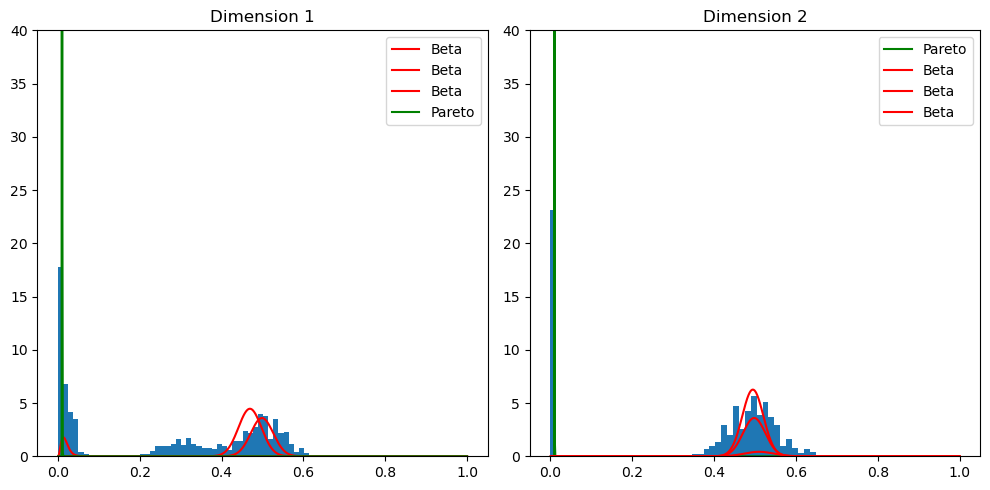

Iteration 2600: Loss = -925807552.0
Iteration 2800: Loss = -1548283520.0
probs_beta [[4.4936064e-01 5.8990900e-06]
 [1.7884741e-02 5.0999993e-01]
 [5.0095659e-01 5.0325441e-01]
 [5.6816701e-02 4.9623743e-01]]


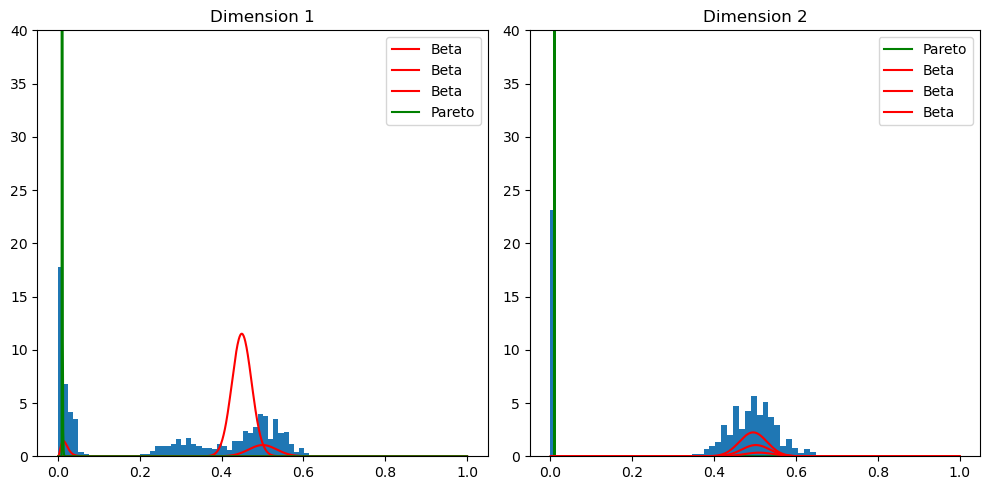

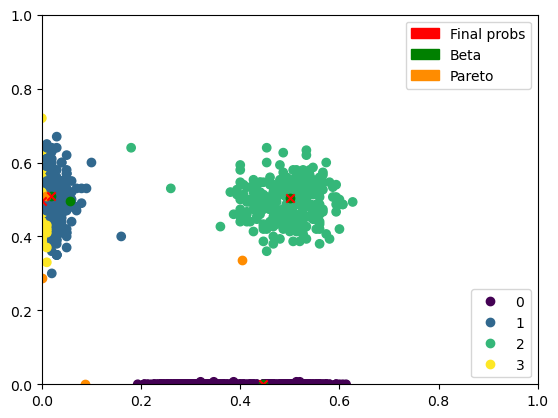

In [8]:
mb = mobster_MV(NV, DP, K = 4, seed = 45)
mb.fit(num_iter = 3000, lr = 0.001)

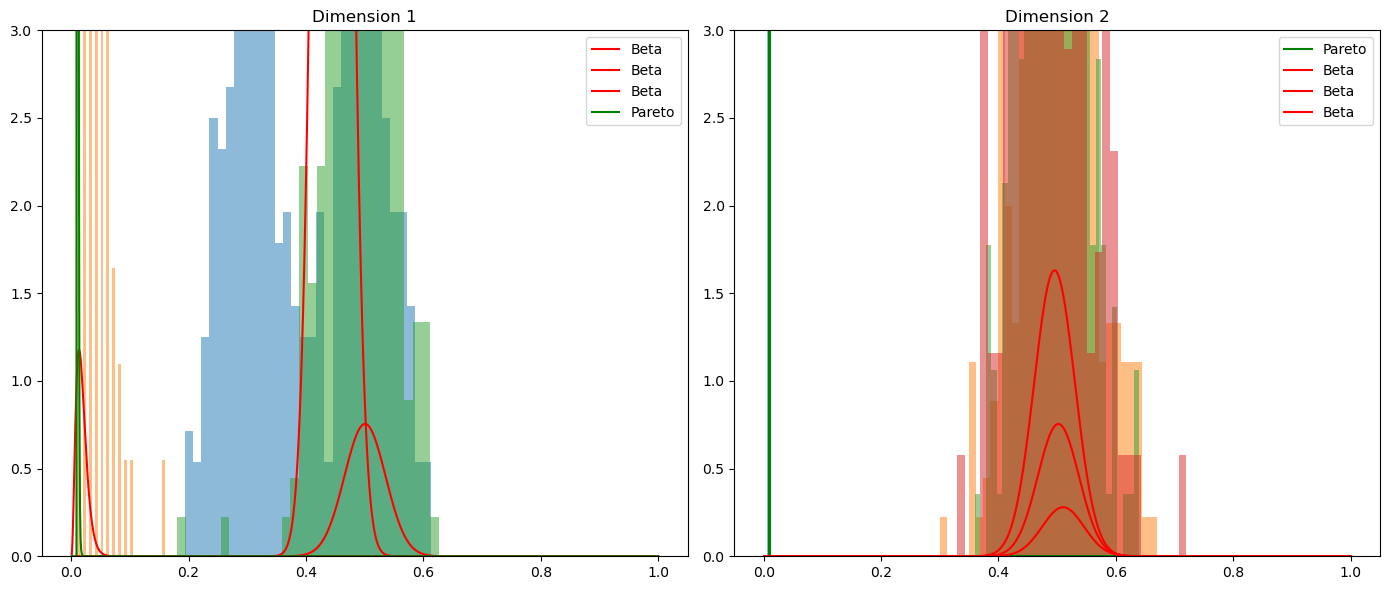

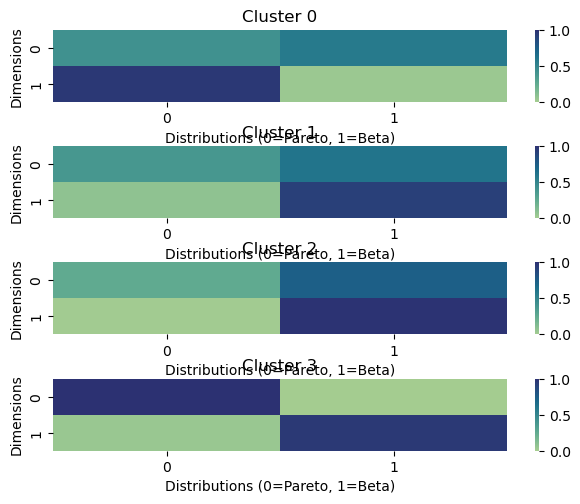

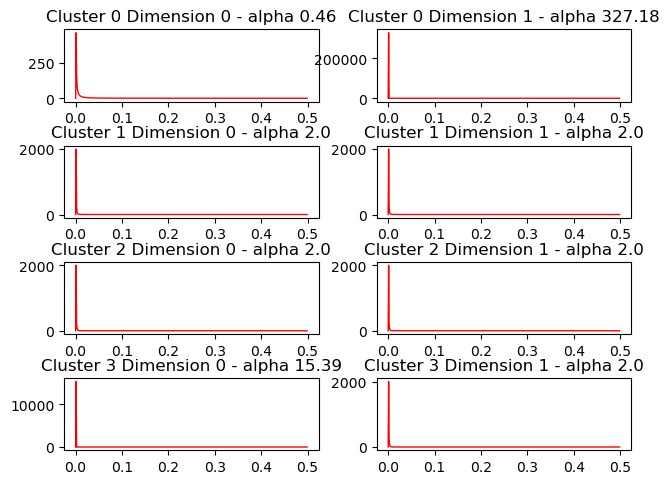

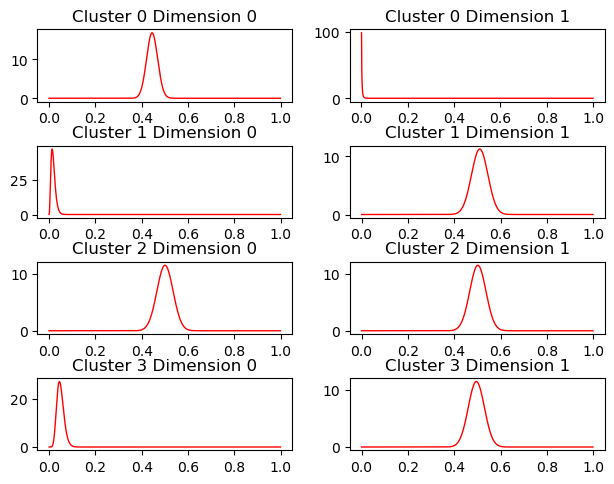

In [9]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

In [ ]:
mb.params

{'probs_beta': tensor([[0.5020, 0.4978],
         [0.0868, 0.1982]]),
 'probs_pareto': tensor([[0.2345, 0.2076],
         [0.0005, 0.0323]]),
 'weights': tensor([0.3333, 0.6667]),
 'delta': tensor([[[0.0159, 0.9841],
          [0.0281, 0.9719]],
 
         [[0.9510, 0.0490],
          [0.0079, 0.9921]]]),
 'alpha_pareto': tensor([[1.9998, 1.9998],
         [4.8085, 1.9644]]),
 'phi_beta': tensor([[0.5020, 0.4978],
         [0.0873, 0.1987]]),
 'k_beta': tensor([[422.2722, 422.2736],
         [229.1141, 544.1751]]),
 'responsib': tensor([[9.9394e-38, 2.5693e-35, 1.5907e-30,  ..., 1.0000e+00, 1.0000e+00,
          1.0000e+00],
         [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]]),
 'cluster_assignments': tensor([1, 1, 1,  ..., 0, 0, 0])}

### With 3 beta components

In [ ]:
N1 = 1000
N2 = 800
N3 = 1000

NV1, DP1 = beta_binomial_component(phi_beta_x = 0.1, k_beta_x = 250, phi_beta_y = 0.1, k_beta_y= 250, n=150, N=N1, seed=seed)
NV2, DP2 = beta_binomial_component(phi_beta_x = 0.5, k_beta_x = 250, phi_beta_y = 0.5, k_beta_y= 250, n=150, N=N2, seed=seed)
NV3, DP3 = beta_binomial_component(phi_beta_x = 0.3, k_beta_x = 250, phi_beta_y = 0.3, k_beta_y= 250, n=150, N=N3, seed=seed)

NV = torch.concat((NV1,NV2))
NV = torch.concat((NV,NV3))
print(NV.shape)
# print(NV)
DP = torch.concat((DP1,DP2))
DP = torch.concat((DP,DP3))
print(DP.shape)
# print(DP)

In [ ]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels_3 = np.ones(N3) * 3

labels = np.concatenate((labels_1, labels_2))
labels = np.concatenate((labels, labels_3))

In [ ]:
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

In [ ]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Sample S2")
plt.show()

In [ ]:
mb = mobster_MV(NV, DP, K = 3, seed = 821)
mb.fit(num_iter = 3000, lr = 0.001)

In [ ]:
mb.params

In [ ]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

### With 3 beta components (1 private)

In [ ]:
N1 = 1000
N2 = 800
N3 = 1000

NV1, DP1 = beta_binomial_component(phi_beta_x = 0.4, k_beta_x = 250, phi_beta_y = 0.0001, k_beta_y= 250, n=150, N=N1, seed=seed)
NV2, DP2 = beta_binomial_component(phi_beta_x = 0.5, k_beta_x = 250, phi_beta_y = 0.5, k_beta_y= 250, n=150, N=N2, seed=seed)
NV3, DP3 = beta_binomial_component(phi_beta_x = 0.3, k_beta_x = 250, phi_beta_y = 0.3, k_beta_y= 250, n=150, N=N3, seed=seed)

NV = torch.concat((NV1,NV2))
NV = torch.concat((NV,NV3))
print(NV.shape)
# print(NV)
DP = torch.concat((DP1,DP2))
DP = torch.concat((DP,DP3))
print(DP.shape)
# print(DP)

In [ ]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels_3 = np.ones(N3) * 3

labels = np.concatenate((labels_1, labels_2))
labels = np.concatenate((labels, labels_3))

In [ ]:
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

In [ ]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Sample S2")
plt.show()

In [ ]:
mb = mobster_MV(NV, DP, K = 3, seed = 48)
mb.fit(num_iter = 3000, lr = 0.001)

In [ ]:
mb.params

In [ ]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)